# Retrospective analysis

In [7]:
import os
import numpy as np
import seaborn as sns
from pymbar import BAR
import matplotlib.pyplot as plt
import seaborn
import numpy as np
from glob import glob
import pickle
from simtk.openmm import unit
import bz2
from beryllium import plotting, stats
import pandas as pd
import json
import tqdm
from openmmtools.constants import kB
import networkx as nx
import random
temperature = 300.0 * unit.kelvin
kT = kB * temperature

In [8]:
with bz2.BZ2File('../data/work-13420.pkl.bz2', 'r') as infile:
    work = pickle.load(infile)

In [9]:
work.replace([np.inf, -np.inf], np.nan)
work = work.dropna()

def _strip_outliers(w,n_devs=100):
    w = [x for x in w if np.abs(x) < 10**4]
    mean = np.mean(w)
    std = np.std(w)
    good_w = [x for x in w if np.abs(x-mean) < n_devs*std]
    return np.asarray(good_w)

In [193]:
retro_jsons = [x for x in os.listdir('/Users/brucemah/bin/covid-moonshot-new/synthetic-enumeration/') if 'retro' in x and 'json' in x]

In [198]:
details = {}

for x in retro_jsons:
    with open(f'/Users/brucemah/bin/covid-moonshot-new/synthetic-enumeration/{x}', 'r') as f:
        new = json.load(f)
        details = {**details, **new}
        print(len(details))

284
572
732


In [199]:
projects = {
    'complex' : 'PROJ13420',
    'solvent' : 'PROJ13421'}

import time
plotting = False

def _get_works(df,run,project,GEN=None):
    works = df[(df['RUN']==run)]
    
    if GEN:
        works = works[works['GEN']==GEN]

    f = works[works['PROJ']==project].forward_work
    r = works[works['PROJ']==project].reverse_work   
    return f, r

n_bootstrap = 100
for d in tqdm.tqdm(details.values()):
    RUN = d['directory']
    if plotting:
        fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(10,5))
    for i, phase in enumerate(projects.keys()):
        if plotting:
            axes[i].set_title(phase)
        
        all_forward = []
        all_reverse = []
        # There will be 6 gens for this project I think
        for gen_id in range(0,7):
            f_works, r_works = _get_works(work,RUN,projects[phase],GEN=f'GEN{gen_id}')
            f_works = _strip_outliers(f_works)       
            r_works = _strip_outliers(r_works)
            d[f'{phase}_fes_GEN{gen_id}'] = []
            d[f'{phase}_dfes_GEN{gen_id}'] = []

            if len(f_works) > 10 and len(r_works) > 10:
                for _ in range(n_bootstrap):
                    f = random.choices(f_works, k=len(f_works))
                    r = random.choices(r_works, k=len(r_works))
                    fe, err = BAR(np.asarray(f), np.asarray(f)) 
                    d[f'{phase}_fes_GEN{gen_id}'].append(fe)
                    d[f'{phase}_dfes_GEN{gen_id}'].append(err)

            all_forward.extend(f_works)
            all_reverse.extend(r_works)
#         print(all_forward)
        if len(all_forward) < 10:
            print(f'Cant calculate {RUN} {phase}')
            continue
        if len(all_reverse) < 10:
            print(f'Cant calculate {RUN} {phase}')
            continue
        if plotting:
            sns.kdeplot(all_forward,shade=True,color='cornflowerblue',ax=axes[i])
            sns.rugplot(all_forward,ax=axes[i],color='cornflowerblue',alpha=0.5,label=f'forward : N={len(f_works)}')
            sns.rugplot(all_forward,ax=axes[i],color='darkblue',label=f'forward (gen0) : N={len(f_works)}')
            sns.rugplot([-x for x in all_reverse],ax=axes[i],color='mediumvioletred',label=f'reverse (gen0) : N={len(r_works)}')
            sns.kdeplot([-x for x in all_reverse],shade=True,color='hotpink',ax=axes[i])
            sns.rugplot([-x for x in all_reverse],ax=axes[i],color='hotpink',alpha=0.5,label=f'reverse : N={len(r_works)}')

        if any([True for x in [all_reverse, all_forward] if len(x) < 20]):
            print(f'Cant calculate {RUN} {phase}')
        else:
            # TODO add bootstrapping here
            d[f'{phase}_fes'] = BAR(np.asarray(all_forward), np.asarray(all_reverse))
#             d[f'n_{phase}'] = len(all_forward) + len(all_reverse)
              
        
    if plotting:    
        fig.suptitle(f"{RUN}: {d['protein'].split('_')[0]} {d['start']}-{d['end']}", fontsize=16)
        fig.subplots_adjust(top=0.9,wspace=0.15)
        axes[0].legend()
        axes[1].legend()
        plt.show()

  0%|          | 0/732 [00:00<?, ?it/s]/Users/brucemah/miniconda3/lib/python3.6/site-packages/pymbar/bar.py:373: RuntimeWarning:

invalid value encountered in sqrt

/Users/brucemah/miniconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning:

Mean of empty slice.

/Users/brucemah/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars

/Users/brucemah/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:217: RuntimeWarning:

Degrees of freedom <= 0 for slice

/Users/brucemah/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning:

invalid value encountered in true_divide

/Users/brucemah/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning:

invalid value encountered in double_scalars

  0%|          | 1/732 [00:01<12:40,  1.04s/it]

Cant calculate RUN7801 solvent


  0%|          | 2/732 [00:01<11:40,  1.04it/s]

Cant calculate RUN7802 solvent


  0%|          | 3/732 [00:02<11:12,  1.08it/s]

Cant calculate RUN7803 solvent


  1%|          | 4/732 [00:03<10:45,  1.13it/s]

Cant calculate RUN7804 solvent


  1%|          | 5/732 [00:04<10:15,  1.18it/s]

Cant calculate RUN7805 solvent


  1%|          | 6/732 [00:05<10:03,  1.20it/s]

Cant calculate RUN7806 solvent


  1%|          | 7/732 [00:05<09:37,  1.26it/s]

Cant calculate RUN7807 solvent


  1%|          | 8/732 [00:06<09:19,  1.29it/s]

Cant calculate RUN7808 solvent


  1%|          | 9/732 [00:07<09:08,  1.32it/s]

Cant calculate RUN7809 solvent


  1%|▏         | 10/732 [00:07<09:00,  1.34it/s]

Cant calculate RUN7810 solvent


  2%|▏         | 11/732 [00:08<08:59,  1.34it/s]

Cant calculate RUN7811 solvent


  2%|▏         | 12/732 [00:09<09:13,  1.30it/s]

Cant calculate RUN7812 solvent


  2%|▏         | 13/732 [00:10<09:25,  1.27it/s]

Cant calculate RUN7813 solvent


  2%|▏         | 14/732 [00:11<09:24,  1.27it/s]

Cant calculate RUN7814 solvent


  2%|▏         | 15/732 [00:11<09:20,  1.28it/s]

Cant calculate RUN7815 solvent


  2%|▏         | 16/732 [00:12<09:42,  1.23it/s]

Cant calculate RUN7816 solvent


  2%|▏         | 17/732 [00:13<09:41,  1.23it/s]

Cant calculate RUN7817 solvent


  2%|▏         | 18/732 [00:14<09:42,  1.22it/s]

Cant calculate RUN7818 solvent


  3%|▎         | 19/732 [00:15<09:49,  1.21it/s]

Cant calculate RUN7819 solvent


  3%|▎         | 20/732 [00:16<09:49,  1.21it/s]

Cant calculate RUN7820 solvent


  3%|▎         | 21/732 [00:17<10:22,  1.14it/s]

Cant calculate RUN7821 solvent


  3%|▎         | 22/732 [00:17<10:26,  1.13it/s]

Cant calculate RUN7822 solvent


  3%|▎         | 23/732 [00:18<10:18,  1.15it/s]

Cant calculate RUN7823 solvent


  3%|▎         | 24/732 [00:19<10:07,  1.17it/s]

Cant calculate RUN7824 solvent


  3%|▎         | 25/732 [00:20<09:54,  1.19it/s]

Cant calculate RUN7825 solvent


  4%|▎         | 26/732 [00:21<09:48,  1.20it/s]

Cant calculate RUN7826 solvent


  4%|▎         | 27/732 [00:21<09:25,  1.25it/s]

Cant calculate RUN7827 solvent


  4%|▍         | 28/732 [00:22<09:25,  1.24it/s]

Cant calculate RUN7828 solvent


  4%|▍         | 29/732 [00:23<09:25,  1.24it/s]

Cant calculate RUN7829 solvent


  4%|▍         | 30/732 [00:24<09:14,  1.27it/s]

Cant calculate RUN7830 solvent


  4%|▍         | 31/732 [00:25<09:03,  1.29it/s]

Cant calculate RUN7831 solvent
Cant calculate RUN7832 complex


  4%|▍         | 32/732 [00:25<08:57,  1.30it/s]

Cant calculate RUN7832 solvent
Cant calculate RUN7833 complex


  5%|▍         | 33/732 [00:26<08:37,  1.35it/s]

Cant calculate RUN7833 solvent
Cant calculate RUN7834 complex


  5%|▍         | 34/732 [00:27<08:35,  1.35it/s]

Cant calculate RUN7834 solvent
Cant calculate RUN7835 complex


  5%|▍         | 35/732 [00:27<08:18,  1.40it/s]

Cant calculate RUN7835 solvent


  5%|▍         | 36/732 [00:28<08:23,  1.38it/s]

Cant calculate RUN7836 solvent


  5%|▌         | 37/732 [00:29<08:30,  1.36it/s]

Cant calculate RUN7837 solvent


  5%|▌         | 38/732 [00:30<08:44,  1.32it/s]

Cant calculate RUN7838 solvent


  5%|▌         | 39/732 [00:30<08:54,  1.30it/s]

Cant calculate RUN7839 solvent
Cant calculate RUN7840 complex


  5%|▌         | 40/732 [00:31<08:58,  1.29it/s]

Cant calculate RUN7840 solvent


  6%|▌         | 41/732 [00:32<09:10,  1.26it/s]

Cant calculate RUN7841 solvent


  6%|▌         | 42/732 [00:33<09:15,  1.24it/s]

Cant calculate RUN7842 solvent


  6%|▌         | 43/732 [00:34<09:26,  1.22it/s]

Cant calculate RUN7843 solvent


  6%|▌         | 44/732 [00:35<09:11,  1.25it/s]

Cant calculate RUN7844 solvent


  6%|▌         | 45/732 [00:35<09:19,  1.23it/s]

Cant calculate RUN7845 solvent


  6%|▋         | 46/732 [00:36<09:07,  1.25it/s]

Cant calculate RUN7846 solvent


  6%|▋         | 47/732 [00:37<08:59,  1.27it/s]

Cant calculate RUN7847 solvent


  7%|▋         | 48/732 [00:38<08:50,  1.29it/s]

Cant calculate RUN7848 solvent


  7%|▋         | 49/732 [00:38<08:44,  1.30it/s]

Cant calculate RUN7849 solvent


  7%|▋         | 50/732 [00:39<08:56,  1.27it/s]

Cant calculate RUN7850 solvent


  7%|▋         | 51/732 [00:40<09:06,  1.25it/s]

Cant calculate RUN7851 solvent


  7%|▋         | 52/732 [00:41<08:55,  1.27it/s]

Cant calculate RUN7852 solvent


  7%|▋         | 53/732 [00:42<08:53,  1.27it/s]

Cant calculate RUN7853 solvent


  7%|▋         | 54/732 [00:42<08:56,  1.26it/s]

Cant calculate RUN7854 solvent


  8%|▊         | 55/732 [00:43<08:53,  1.27it/s]

Cant calculate RUN7855 solvent


  8%|▊         | 56/732 [00:44<08:56,  1.26it/s]

Cant calculate RUN7856 solvent


  8%|▊         | 57/732 [00:45<09:28,  1.19it/s]

Cant calculate RUN7857 solvent


  8%|▊         | 58/732 [00:46<09:17,  1.21it/s]

Cant calculate RUN7858 solvent


  8%|▊         | 59/732 [00:47<09:03,  1.24it/s]

Cant calculate RUN7859 solvent


  8%|▊         | 60/732 [00:47<08:51,  1.26it/s]

Cant calculate RUN7860 solvent


  8%|▊         | 61/732 [00:48<09:06,  1.23it/s]

Cant calculate RUN7861 solvent


  8%|▊         | 62/732 [00:49<08:55,  1.25it/s]

Cant calculate RUN7862 solvent


  9%|▊         | 63/732 [00:50<08:46,  1.27it/s]

Cant calculate RUN7863 solvent


  9%|▊         | 64/732 [00:50<08:39,  1.29it/s]

Cant calculate RUN7864 solvent


  9%|▉         | 65/732 [00:51<08:33,  1.30it/s]

Cant calculate RUN7865 solvent


  9%|▉         | 66/732 [00:52<08:31,  1.30it/s]

Cant calculate RUN7866 solvent


  9%|▉         | 67/732 [00:53<08:37,  1.28it/s]

Cant calculate RUN7867 solvent


  9%|▉         | 68/732 [00:54<08:32,  1.29it/s]

Cant calculate RUN7868 solvent


  9%|▉         | 69/732 [00:54<08:42,  1.27it/s]

Cant calculate RUN7869 solvent


 10%|▉         | 70/732 [00:55<08:41,  1.27it/s]

Cant calculate RUN7870 solvent


 10%|▉         | 71/732 [00:56<08:33,  1.29it/s]

Cant calculate RUN7871 solvent


 10%|▉         | 72/732 [00:57<08:29,  1.29it/s]

Cant calculate RUN7872 solvent


 10%|▉         | 73/732 [00:57<08:22,  1.31it/s]

Cant calculate RUN7873 solvent


 10%|█         | 74/732 [00:58<08:20,  1.31it/s]

Cant calculate RUN7874 solvent


 10%|█         | 75/732 [00:59<08:24,  1.30it/s]

Cant calculate RUN7875 solvent


 10%|█         | 76/732 [01:00<08:21,  1.31it/s]

Cant calculate RUN7876 solvent


 11%|█         | 77/732 [01:00<08:19,  1.31it/s]

Cant calculate RUN7877 solvent


 11%|█         | 78/732 [01:01<08:19,  1.31it/s]

Cant calculate RUN7878 solvent


 11%|█         | 79/732 [01:02<08:27,  1.29it/s]

Cant calculate RUN7879 solvent


 11%|█         | 80/732 [01:03<08:37,  1.26it/s]

Cant calculate RUN7880 solvent
Cant calculate RUN7881 complex


 11%|█         | 81/732 [01:04<08:31,  1.27it/s]

Cant calculate RUN7881 solvent


 11%|█         | 82/732 [01:04<08:28,  1.28it/s]

Cant calculate RUN7882 solvent


 11%|█▏        | 83/732 [01:05<08:20,  1.30it/s]

Cant calculate RUN7883 solvent
Cant calculate RUN7884 complex


 11%|█▏        | 84/732 [01:06<08:15,  1.31it/s]

Cant calculate RUN7884 solvent


 12%|█▏        | 85/732 [01:07<08:10,  1.32it/s]

Cant calculate RUN7885 solvent


 12%|█▏        | 86/732 [01:07<08:05,  1.33it/s]

Cant calculate RUN7886 solvent


 12%|█▏        | 87/732 [01:08<08:03,  1.34it/s]

Cant calculate RUN7887 solvent


 12%|█▏        | 88/732 [01:09<07:58,  1.35it/s]

Cant calculate RUN7888 solvent


 12%|█▏        | 89/732 [01:10<07:56,  1.35it/s]

Cant calculate RUN7889 solvent


 12%|█▏        | 90/732 [01:10<08:10,  1.31it/s]

Cant calculate RUN7890 solvent


 12%|█▏        | 91/732 [01:11<08:05,  1.32it/s]

Cant calculate RUN7891 solvent


 13%|█▎        | 92/732 [01:12<08:04,  1.32it/s]

Cant calculate RUN7892 solvent


 13%|█▎        | 93/732 [01:13<08:06,  1.31it/s]

Cant calculate RUN7893 solvent


 13%|█▎        | 94/732 [01:13<08:05,  1.31it/s]

Cant calculate RUN7894 solvent
Cant calculate RUN7895 complex


 13%|█▎        | 95/732 [01:14<08:04,  1.31it/s]

Cant calculate RUN7895 solvent


 13%|█▎        | 96/732 [01:15<08:14,  1.29it/s]

Cant calculate RUN7896 solvent


 13%|█▎        | 97/732 [01:16<08:11,  1.29it/s]

Cant calculate RUN7897 solvent


 13%|█▎        | 98/732 [01:17<08:06,  1.30it/s]

Cant calculate RUN7898 solvent
Cant calculate RUN7899 complex


 14%|█▎        | 99/732 [01:17<08:03,  1.31it/s]

Cant calculate RUN7899 solvent
Cant calculate RUN7900 complex


 14%|█▎        | 100/732 [01:18<07:59,  1.32it/s]

Cant calculate RUN7900 solvent


 14%|█▍        | 101/732 [01:19<08:00,  1.31it/s]

Cant calculate RUN7901 solvent


 14%|█▍        | 102/732 [01:20<08:31,  1.23it/s]

Cant calculate RUN7902 solvent


 14%|█▍        | 103/732 [01:21<08:34,  1.22it/s]

Cant calculate RUN7903 solvent


 14%|█▍        | 104/732 [01:21<08:19,  1.26it/s]

Cant calculate RUN7904 solvent


 14%|█▍        | 105/732 [01:22<08:12,  1.27it/s]

Cant calculate RUN7905 solvent


 14%|█▍        | 106/732 [01:23<08:09,  1.28it/s]

Cant calculate RUN7906 solvent


 15%|█▍        | 107/732 [01:24<08:02,  1.29it/s]

Cant calculate RUN7907 solvent


 15%|█▍        | 108/732 [01:24<07:56,  1.31it/s]

Cant calculate RUN7908 solvent


 15%|█▍        | 109/732 [01:25<08:02,  1.29it/s]

Cant calculate RUN7909 solvent


 15%|█▌        | 110/732 [01:26<07:56,  1.31it/s]

Cant calculate RUN7910 solvent
Cant calculate RUN7911 complex


 15%|█▌        | 111/732 [01:27<07:38,  1.35it/s]

Cant calculate RUN7911 solvent


 15%|█▌        | 112/732 [01:27<07:41,  1.34it/s]

Cant calculate RUN7912 solvent
Cant calculate RUN7913 complex


 15%|█▌        | 113/732 [01:28<07:28,  1.38it/s]

Cant calculate RUN7913 solvent


 16%|█▌        | 114/732 [01:29<07:29,  1.37it/s]

Cant calculate RUN7914 solvent
Cant calculate RUN7915 complex


 16%|█▌        | 115/732 [01:29<07:18,  1.41it/s]

Cant calculate RUN7915 solvent


 16%|█▌        | 116/732 [01:30<07:34,  1.36it/s]

Cant calculate RUN7916 solvent


 16%|█▌        | 117/732 [01:31<07:32,  1.36it/s]

Cant calculate RUN7917 solvent


 16%|█▌        | 118/732 [01:32<07:37,  1.34it/s]

Cant calculate RUN7918 solvent


 16%|█▋        | 119/732 [01:32<07:37,  1.34it/s]

Cant calculate RUN7919 solvent


 16%|█▋        | 120/732 [01:33<07:35,  1.34it/s]

Cant calculate RUN7920 solvent


 17%|█▋        | 121/732 [01:34<07:44,  1.32it/s]

Cant calculate RUN7921 solvent


 17%|█▋        | 122/732 [01:35<07:38,  1.33it/s]

Cant calculate RUN7922 solvent


 17%|█▋        | 123/732 [01:35<07:35,  1.34it/s]

Cant calculate RUN7923 solvent


 17%|█▋        | 124/732 [01:36<07:36,  1.33it/s]

Cant calculate RUN7924 solvent


 17%|█▋        | 125/732 [01:37<07:55,  1.28it/s]

Cant calculate RUN7925 solvent


 17%|█▋        | 126/732 [01:38<07:55,  1.27it/s]

Cant calculate RUN7926 solvent


 17%|█▋        | 127/732 [01:39<08:06,  1.24it/s]

Cant calculate RUN7927 solvent


 17%|█▋        | 128/732 [01:39<08:07,  1.24it/s]

Cant calculate RUN7928 solvent


 18%|█▊        | 129/732 [01:40<08:00,  1.26it/s]

Cant calculate RUN7929 solvent


 18%|█▊        | 130/732 [01:41<08:08,  1.23it/s]

Cant calculate RUN7930 solvent


 18%|█▊        | 131/732 [01:42<08:17,  1.21it/s]

Cant calculate RUN7931 solvent


 18%|█▊        | 132/732 [01:43<08:23,  1.19it/s]

Cant calculate RUN7932 solvent


 18%|█▊        | 133/732 [01:44<08:22,  1.19it/s]

Cant calculate RUN7933 solvent


 18%|█▊        | 134/732 [01:44<08:04,  1.24it/s]

Cant calculate RUN7934 solvent


 18%|█▊        | 135/732 [01:45<08:05,  1.23it/s]

Cant calculate RUN7935 solvent


 19%|█▊        | 136/732 [01:46<07:51,  1.26it/s]

Cant calculate RUN7936 solvent
Cant calculate RUN7937 complex


 19%|█▊        | 137/732 [01:47<07:43,  1.28it/s]

Cant calculate RUN7937 solvent
Cant calculate RUN7938 complex


 19%|█▉        | 138/732 [01:47<07:35,  1.30it/s]

Cant calculate RUN7938 solvent


 19%|█▉        | 139/732 [01:48<07:33,  1.31it/s]

Cant calculate RUN7939 solvent


 19%|█▉        | 140/732 [01:49<07:27,  1.32it/s]

Cant calculate RUN7940 solvent
Cant calculate RUN7941 complex


 19%|█▉        | 141/732 [01:50<07:28,  1.32it/s]

Cant calculate RUN7941 solvent
Cant calculate RUN7942 complex


 19%|█▉        | 142/732 [01:51<07:30,  1.31it/s]

Cant calculate RUN7942 solvent


 20%|█▉        | 143/732 [01:51<07:38,  1.28it/s]

Cant calculate RUN7943 solvent


 20%|█▉        | 144/732 [01:52<07:38,  1.28it/s]

Cant calculate RUN7944 solvent


 20%|█▉        | 145/732 [01:53<07:50,  1.25it/s]

Cant calculate RUN7945 solvent


 20%|█▉        | 146/732 [01:54<07:51,  1.24it/s]

Cant calculate RUN7946 solvent


 20%|██        | 147/732 [01:55<08:03,  1.21it/s]

Cant calculate RUN7947 solvent


 20%|██        | 148/732 [01:55<07:54,  1.23it/s]

Cant calculate RUN7948 solvent


 20%|██        | 149/732 [01:56<07:47,  1.25it/s]

Cant calculate RUN7949 solvent


 20%|██        | 150/732 [01:57<07:46,  1.25it/s]

Cant calculate RUN7950 solvent


 21%|██        | 151/732 [01:58<07:49,  1.24it/s]

Cant calculate RUN7951 solvent


 21%|██        | 152/732 [01:59<07:51,  1.23it/s]

Cant calculate RUN7952 solvent


 21%|██        | 153/732 [01:59<07:52,  1.23it/s]

Cant calculate RUN7953 solvent


 21%|██        | 154/732 [02:00<08:12,  1.17it/s]

Cant calculate RUN7954 solvent


 21%|██        | 155/732 [02:01<07:59,  1.20it/s]

Cant calculate RUN7955 solvent


 21%|██▏       | 156/732 [02:02<07:49,  1.23it/s]

Cant calculate RUN7956 solvent


 21%|██▏       | 157/732 [02:03<07:44,  1.24it/s]

Cant calculate RUN7957 solvent


 22%|██▏       | 158/732 [02:04<07:52,  1.21it/s]

Cant calculate RUN7958 solvent


 22%|██▏       | 159/732 [02:04<07:46,  1.23it/s]

Cant calculate RUN7959 solvent


 22%|██▏       | 160/732 [02:05<07:46,  1.23it/s]

Cant calculate RUN7960 solvent


 22%|██▏       | 161/732 [02:06<07:44,  1.23it/s]

Cant calculate RUN7961 solvent


 22%|██▏       | 162/732 [02:07<07:38,  1.24it/s]

Cant calculate RUN7962 solvent


 22%|██▏       | 163/732 [02:08<07:28,  1.27it/s]

Cant calculate RUN7963 solvent


 22%|██▏       | 164/732 [02:08<07:28,  1.27it/s]

Cant calculate RUN7964 solvent


 23%|██▎       | 165/732 [02:09<07:22,  1.28it/s]

Cant calculate RUN7965 solvent


 23%|██▎       | 166/732 [02:10<07:15,  1.30it/s]

Cant calculate RUN7966 solvent


 23%|██▎       | 167/732 [02:11<07:10,  1.31it/s]

Cant calculate RUN7967 solvent


 23%|██▎       | 168/732 [02:11<07:06,  1.32it/s]

Cant calculate RUN7968 solvent


 23%|██▎       | 169/732 [02:12<07:04,  1.33it/s]

Cant calculate RUN7969 solvent


 23%|██▎       | 170/732 [02:13<07:13,  1.30it/s]

Cant calculate RUN7970 solvent


 23%|██▎       | 171/732 [02:14<07:07,  1.31it/s]

Cant calculate RUN7971 solvent
Cant calculate RUN7972 complex


 23%|██▎       | 172/732 [02:14<07:08,  1.31it/s]

Cant calculate RUN7972 solvent


 24%|██▎       | 173/732 [02:15<07:09,  1.30it/s]

Cant calculate RUN7973 solvent


 24%|██▍       | 174/732 [02:16<07:03,  1.32it/s]

Cant calculate RUN7974 solvent
Cant calculate RUN7975 complex


 24%|██▍       | 175/732 [02:17<06:47,  1.37it/s]

Cant calculate RUN7975 solvent
Cant calculate RUN7976 complex


 24%|██▍       | 176/732 [02:17<06:50,  1.35it/s]

Cant calculate RUN7976 solvent
Cant calculate RUN7977 complex


 24%|██▍       | 177/732 [02:18<06:42,  1.38it/s]

Cant calculate RUN7977 solvent
Cant calculate RUN7978 complex


 24%|██▍       | 178/732 [02:19<06:51,  1.34it/s]

Cant calculate RUN7978 solvent


 24%|██▍       | 179/732 [02:20<07:13,  1.27it/s]

Cant calculate RUN7979 solvent


 25%|██▍       | 180/732 [02:21<07:14,  1.27it/s]

Cant calculate RUN7980 solvent


 25%|██▍       | 181/732 [02:21<07:06,  1.29it/s]

Cant calculate RUN7981 solvent


 25%|██▍       | 182/732 [02:22<07:14,  1.27it/s]

Cant calculate RUN7982 solvent


 25%|██▌       | 183/732 [02:23<07:11,  1.27it/s]

Cant calculate RUN7983 solvent


 25%|██▌       | 184/732 [02:24<07:03,  1.29it/s]

Cant calculate RUN7984 solvent


 25%|██▌       | 185/732 [02:24<07:00,  1.30it/s]

Cant calculate RUN7985 solvent


 25%|██▌       | 186/732 [02:25<07:06,  1.28it/s]

Cant calculate RUN7986 solvent


 26%|██▌       | 187/732 [02:26<07:01,  1.29it/s]

Cant calculate RUN7987 solvent


 26%|██▌       | 188/732 [02:27<07:08,  1.27it/s]

Cant calculate RUN7988 solvent


 26%|██▌       | 189/732 [02:28<07:02,  1.29it/s]

Cant calculate RUN7989 solvent


 26%|██▌       | 190/732 [02:28<07:06,  1.27it/s]

Cant calculate RUN7990 solvent


 26%|██▌       | 191/732 [02:29<06:58,  1.29it/s]

Cant calculate RUN7991 solvent


 26%|██▌       | 192/732 [02:30<06:54,  1.30it/s]

Cant calculate RUN7992 solvent


 26%|██▋       | 193/732 [02:31<06:48,  1.32it/s]

Cant calculate RUN7993 solvent


 27%|██▋       | 194/732 [02:31<06:45,  1.33it/s]

Cant calculate RUN7994 solvent


 27%|██▋       | 195/732 [02:32<06:48,  1.32it/s]

Cant calculate RUN7995 solvent


 27%|██▋       | 196/732 [02:33<06:49,  1.31it/s]

Cant calculate RUN7996 solvent


 27%|██▋       | 197/732 [02:34<06:48,  1.31it/s]

Cant calculate RUN7997 solvent


 27%|██▋       | 198/732 [02:34<06:52,  1.30it/s]

Cant calculate RUN7998 solvent


 27%|██▋       | 199/732 [02:35<07:00,  1.27it/s]

Cant calculate RUN7999 solvent


 27%|██▋       | 200/732 [02:36<07:25,  1.19it/s]

Cant calculate RUN8000 solvent


 27%|██▋       | 201/732 [02:37<07:49,  1.13it/s]

Cant calculate RUN8001 solvent


 28%|██▊       | 202/732 [02:38<07:49,  1.13it/s]

Cant calculate RUN8002 solvent
Cant calculate RUN8003 complex


 28%|██▊       | 203/732 [02:39<07:55,  1.11it/s]

Cant calculate RUN8003 solvent


 28%|██▊       | 204/732 [02:40<07:46,  1.13it/s]

Cant calculate RUN8004 solvent


 28%|██▊       | 205/732 [02:41<07:37,  1.15it/s]

Cant calculate RUN8005 solvent


 28%|██▊       | 206/732 [02:42<07:31,  1.17it/s]

Cant calculate RUN8006 solvent


 28%|██▊       | 207/732 [02:42<07:21,  1.19it/s]

Cant calculate RUN8007 solvent


 28%|██▊       | 208/732 [02:43<07:08,  1.22it/s]

Cant calculate RUN8008 solvent


 29%|██▊       | 209/732 [02:44<07:13,  1.21it/s]

Cant calculate RUN8009 solvent
Cant calculate RUN8010 complex


 29%|██▊       | 210/732 [02:45<07:18,  1.19it/s]

Cant calculate RUN8010 solvent


 29%|██▉       | 211/732 [02:46<07:07,  1.22it/s]

Cant calculate RUN8011 solvent


 29%|██▉       | 212/732 [02:46<07:16,  1.19it/s]

Cant calculate RUN8012 solvent


 29%|██▉       | 213/732 [02:47<07:20,  1.18it/s]

Cant calculate RUN8013 solvent
Cant calculate RUN8014 complex


 29%|██▉       | 214/732 [02:48<07:04,  1.22it/s]

Cant calculate RUN8014 solvent


 29%|██▉       | 215/732 [02:49<07:05,  1.22it/s]

Cant calculate RUN8015 solvent


 30%|██▉       | 216/732 [02:50<07:04,  1.22it/s]

Cant calculate RUN8016 solvent


 30%|██▉       | 217/732 [02:50<06:55,  1.24it/s]

Cant calculate RUN8017 solvent


 30%|██▉       | 218/732 [02:51<07:05,  1.21it/s]

Cant calculate RUN8018 solvent


 30%|██▉       | 219/732 [02:52<06:58,  1.23it/s]

Cant calculate RUN8019 solvent


 30%|███       | 220/732 [02:53<06:55,  1.23it/s]

Cant calculate RUN8020 solvent


 30%|███       | 221/732 [02:54<07:24,  1.15it/s]

Cant calculate RUN8021 solvent


 30%|███       | 222/732 [02:55<07:41,  1.11it/s]

Cant calculate RUN8022 solvent


 30%|███       | 223/732 [02:56<07:48,  1.09it/s]

Cant calculate RUN8023 solvent


 31%|███       | 224/732 [02:57<07:28,  1.13it/s]

Cant calculate RUN8024 solvent
Cant calculate RUN8025 complex


 31%|███       | 225/732 [02:57<07:10,  1.18it/s]

Cant calculate RUN8025 solvent


 31%|███       | 226/732 [02:58<07:01,  1.20it/s]

Cant calculate RUN8026 solvent
Cant calculate RUN8027 complex


 31%|███       | 227/732 [02:59<06:46,  1.24it/s]

Cant calculate RUN8027 solvent


 31%|███       | 228/732 [03:00<06:34,  1.28it/s]

Cant calculate RUN8028 solvent


 31%|███▏      | 229/732 [03:00<06:25,  1.31it/s]

Cant calculate RUN8029 solvent


 31%|███▏      | 230/732 [03:01<06:16,  1.33it/s]

Cant calculate RUN8030 solvent


 32%|███▏      | 231/732 [03:02<06:15,  1.33it/s]

Cant calculate RUN8031 solvent


 32%|███▏      | 232/732 [03:03<06:15,  1.33it/s]

Cant calculate RUN8032 solvent


 32%|███▏      | 233/732 [03:03<06:14,  1.33it/s]

Cant calculate RUN8033 solvent


 32%|███▏      | 234/732 [03:04<06:13,  1.33it/s]

Cant calculate RUN8034 solvent
Cant calculate RUN8035 complex


 32%|███▏      | 235/732 [03:05<06:13,  1.33it/s]

Cant calculate RUN8035 solvent


 32%|███▏      | 236/732 [03:06<06:10,  1.34it/s]

Cant calculate RUN8036 solvent


 32%|███▏      | 237/732 [03:06<06:08,  1.34it/s]

Cant calculate RUN8037 solvent


 33%|███▎      | 238/732 [03:07<06:16,  1.31it/s]

Cant calculate RUN8038 solvent


 33%|███▎      | 239/732 [03:08<06:23,  1.28it/s]

Cant calculate RUN8039 solvent


 33%|███▎      | 240/732 [03:09<06:18,  1.30it/s]

Cant calculate RUN8040 solvent
Cant calculate RUN8041 complex


 33%|███▎      | 241/732 [03:10<06:13,  1.32it/s]

Cant calculate RUN8041 solvent
Cant calculate RUN8042 complex


 33%|███▎      | 242/732 [03:10<06:09,  1.33it/s]

Cant calculate RUN8042 solvent


 33%|███▎      | 243/732 [03:11<06:16,  1.30it/s]

Cant calculate RUN8043 solvent


 33%|███▎      | 244/732 [03:12<06:19,  1.28it/s]

Cant calculate RUN8044 solvent


 33%|███▎      | 245/732 [03:13<06:22,  1.27it/s]

Cant calculate RUN8045 solvent


 34%|███▎      | 246/732 [03:13<06:16,  1.29it/s]

Cant calculate RUN8046 solvent


 34%|███▎      | 247/732 [03:14<06:19,  1.28it/s]

Cant calculate RUN8047 solvent


 34%|███▍      | 248/732 [03:15<06:13,  1.29it/s]

Cant calculate RUN8048 solvent


 34%|███▍      | 249/732 [03:16<06:08,  1.31it/s]

Cant calculate RUN8049 solvent


 34%|███▍      | 250/732 [03:16<06:05,  1.32it/s]

Cant calculate RUN8050 solvent


 34%|███▍      | 251/732 [03:17<06:02,  1.33it/s]

Cant calculate RUN8051 solvent


 34%|███▍      | 252/732 [03:18<06:09,  1.30it/s]

Cant calculate RUN8052 solvent
Cant calculate RUN8053 complex


 35%|███▍      | 253/732 [03:19<05:56,  1.35it/s]

Cant calculate RUN8053 solvent


 35%|███▍      | 254/732 [03:19<05:54,  1.35it/s]

Cant calculate RUN8054 solvent
Cant calculate RUN8055 complex


 35%|███▍      | 255/732 [03:20<05:46,  1.38it/s]

Cant calculate RUN8055 solvent


 35%|███▍      | 256/732 [03:21<05:46,  1.37it/s]

Cant calculate RUN8056 solvent
Cant calculate RUN8057 complex


 35%|███▌      | 257/732 [03:22<05:40,  1.40it/s]

Cant calculate RUN8057 solvent


 35%|███▌      | 258/732 [03:22<05:47,  1.37it/s]

Cant calculate RUN8058 solvent


 35%|███▌      | 259/732 [03:23<05:48,  1.36it/s]

Cant calculate RUN8059 solvent


 36%|███▌      | 260/732 [03:24<05:48,  1.35it/s]

Cant calculate RUN8060 solvent


 36%|███▌      | 261/732 [03:25<05:49,  1.35it/s]

Cant calculate RUN8061 solvent


 36%|███▌      | 262/732 [03:25<05:47,  1.35it/s]

Cant calculate RUN8062 solvent


 36%|███▌      | 263/732 [03:26<05:44,  1.36it/s]

Cant calculate RUN8063 solvent


 36%|███▌      | 264/732 [03:27<05:43,  1.36it/s]

Cant calculate RUN8064 solvent


 36%|███▌      | 265/732 [03:27<05:43,  1.36it/s]

Cant calculate RUN8065 solvent


 36%|███▋      | 266/732 [03:28<05:44,  1.35it/s]

Cant calculate RUN8066 solvent


 36%|███▋      | 267/732 [03:29<05:44,  1.35it/s]

Cant calculate RUN8067 solvent


 37%|███▋      | 268/732 [03:30<05:44,  1.35it/s]

Cant calculate RUN8068 solvent


 37%|███▋      | 269/732 [03:30<05:39,  1.36it/s]

Cant calculate RUN8069 solvent


 37%|███▋      | 270/732 [03:31<05:34,  1.38it/s]

Cant calculate RUN8070 solvent


 37%|███▋      | 271/732 [03:32<05:36,  1.37it/s]

Cant calculate RUN8071 solvent


 37%|███▋      | 272/732 [03:33<05:36,  1.37it/s]

Cant calculate RUN8072 solvent


 37%|███▋      | 273/732 [03:33<05:36,  1.36it/s]

Cant calculate RUN8073 solvent


 37%|███▋      | 274/732 [03:34<05:36,  1.36it/s]

Cant calculate RUN8074 solvent


 38%|███▊      | 275/732 [03:35<05:36,  1.36it/s]

Cant calculate RUN8075 solvent


 38%|███▊      | 276/732 [03:36<05:36,  1.35it/s]

Cant calculate RUN8076 solvent


 38%|███▊      | 277/732 [03:36<05:36,  1.35it/s]

Cant calculate RUN8077 solvent


 38%|███▊      | 278/732 [03:37<05:35,  1.35it/s]

Cant calculate RUN8078 solvent
Cant calculate RUN8079 complex


 38%|███▊      | 279/732 [03:38<05:34,  1.35it/s]

Cant calculate RUN8079 solvent
Cant calculate RUN8080 complex


 38%|███▊      | 280/732 [03:39<05:33,  1.35it/s]

Cant calculate RUN8080 solvent


 38%|███▊      | 281/732 [03:39<05:33,  1.35it/s]

Cant calculate RUN8081 solvent


 39%|███▊      | 282/732 [03:40<05:33,  1.35it/s]

Cant calculate RUN8082 solvent
Cant calculate RUN8083 complex


 39%|███▊      | 283/732 [03:41<05:34,  1.34it/s]

Cant calculate RUN8083 solvent
Cant calculate RUN8084 complex


 39%|███▉      | 284/732 [03:42<05:38,  1.32it/s]

Cant calculate RUN8084 solvent
Cant calculate RUN8085 complex


 39%|███▉      | 285/732 [03:42<05:32,  1.34it/s]

Cant calculate RUN8085 solvent
Cant calculate RUN8086 complex


 39%|███▉      | 286/732 [03:43<05:29,  1.35it/s]

Cant calculate RUN8086 solvent
Cant calculate RUN8087 complex


 39%|███▉      | 287/732 [03:44<05:23,  1.38it/s]

Cant calculate RUN8087 solvent
Cant calculate RUN8088 complex


 39%|███▉      | 288/732 [03:44<05:19,  1.39it/s]

Cant calculate RUN8088 solvent
Cant calculate RUN8089 complex


 39%|███▉      | 289/732 [03:45<05:17,  1.39it/s]

Cant calculate RUN8089 solvent
Cant calculate RUN8090 complex


 40%|███▉      | 290/732 [03:46<05:22,  1.37it/s]

Cant calculate RUN8090 solvent
Cant calculate RUN8091 complex


 40%|███▉      | 291/732 [03:47<05:31,  1.33it/s]

Cant calculate RUN8091 solvent
Cant calculate RUN8092 complex


 40%|███▉      | 292/732 [03:47<05:27,  1.35it/s]

Cant calculate RUN8092 solvent
Cant calculate RUN8093 complex


 40%|████      | 293/732 [03:48<05:19,  1.37it/s]

Cant calculate RUN8093 solvent
Cant calculate RUN8094 complex


 40%|████      | 294/732 [03:49<05:18,  1.37it/s]

Cant calculate RUN8094 solvent
Cant calculate RUN8095 complex


 40%|████      | 295/732 [03:50<05:14,  1.39it/s]

Cant calculate RUN8095 solvent
Cant calculate RUN8096 complex


 40%|████      | 296/732 [03:50<05:07,  1.42it/s]

Cant calculate RUN8096 solvent
Cant calculate RUN8097 complex


 41%|████      | 297/732 [03:51<05:06,  1.42it/s]

Cant calculate RUN8097 solvent
Cant calculate RUN8098 complex


 41%|████      | 298/732 [03:52<05:02,  1.44it/s]

Cant calculate RUN8098 solvent
Cant calculate RUN8099 complex


 41%|████      | 299/732 [03:52<04:59,  1.45it/s]

Cant calculate RUN8099 solvent
Cant calculate RUN8100 complex


 41%|████      | 300/732 [03:53<04:56,  1.46it/s]

Cant calculate RUN8100 solvent
Cant calculate RUN8101 complex


 41%|████      | 301/732 [03:54<04:58,  1.44it/s]

Cant calculate RUN8101 solvent
Cant calculate RUN8102 complex


 41%|████▏     | 302/732 [03:54<04:55,  1.45it/s]

Cant calculate RUN8102 solvent
Cant calculate RUN8103 complex


 41%|████▏     | 303/732 [03:55<04:58,  1.44it/s]

Cant calculate RUN8103 solvent
Cant calculate RUN8104 complex


 42%|████▏     | 304/732 [03:56<04:55,  1.45it/s]

Cant calculate RUN8104 solvent
Cant calculate RUN8105 complex


 42%|████▏     | 305/732 [03:56<04:59,  1.43it/s]

Cant calculate RUN8105 solvent
Cant calculate RUN8106 complex


 42%|████▏     | 306/732 [03:57<04:59,  1.42it/s]

Cant calculate RUN8106 solvent
Cant calculate RUN8107 complex


 42%|████▏     | 307/732 [03:58<05:03,  1.40it/s]

Cant calculate RUN8107 solvent
Cant calculate RUN8108 complex


 42%|████▏     | 308/732 [03:59<05:30,  1.28it/s]

Cant calculate RUN8108 solvent
Cant calculate RUN8109 complex


 42%|████▏     | 309/732 [04:00<06:05,  1.16it/s]

Cant calculate RUN8109 solvent
Cant calculate RUN8110 complex


 42%|████▏     | 310/732 [04:01<06:13,  1.13it/s]

Cant calculate RUN8110 solvent
Cant calculate RUN8111 complex


 42%|████▏     | 311/732 [04:02<06:08,  1.14it/s]

Cant calculate RUN8111 solvent
Cant calculate RUN8112 complex


 43%|████▎     | 312/732 [04:03<06:06,  1.15it/s]

Cant calculate RUN8112 solvent
Cant calculate RUN8113 complex


 43%|████▎     | 313/732 [04:03<06:16,  1.11it/s]

Cant calculate RUN8113 solvent
Cant calculate RUN8114 complex


 43%|████▎     | 314/732 [04:04<06:10,  1.13it/s]

Cant calculate RUN8114 solvent
Cant calculate RUN8115 complex


 43%|████▎     | 315/732 [04:05<06:11,  1.12it/s]

Cant calculate RUN8115 solvent
Cant calculate RUN8116 complex


 43%|████▎     | 316/732 [04:06<06:03,  1.15it/s]

Cant calculate RUN8116 solvent
Cant calculate RUN8117 complex


 43%|████▎     | 317/732 [04:07<05:53,  1.17it/s]

Cant calculate RUN8117 solvent
Cant calculate RUN8118 complex


 43%|████▎     | 318/732 [04:08<05:43,  1.21it/s]

Cant calculate RUN8118 solvent
Cant calculate RUN8119 complex


 44%|████▎     | 319/732 [04:08<05:32,  1.24it/s]

Cant calculate RUN8119 solvent
Cant calculate RUN8120 complex


 44%|████▎     | 320/732 [04:09<05:20,  1.29it/s]

Cant calculate RUN8120 solvent
Cant calculate RUN8121 complex


 44%|████▍     | 321/732 [04:10<05:08,  1.33it/s]

Cant calculate RUN8121 solvent
Cant calculate RUN8122 complex


 44%|████▍     | 322/732 [04:10<04:59,  1.37it/s]

Cant calculate RUN8122 solvent
Cant calculate RUN8123 complex


 44%|████▍     | 323/732 [04:11<04:52,  1.40it/s]

Cant calculate RUN8123 solvent
Cant calculate RUN8124 complex


 44%|████▍     | 324/732 [04:12<04:53,  1.39it/s]

Cant calculate RUN8124 solvent
Cant calculate RUN8125 complex


 44%|████▍     | 325/732 [04:13<04:52,  1.39it/s]

Cant calculate RUN8125 solvent
Cant calculate RUN8126 complex


 45%|████▍     | 326/732 [04:13<04:48,  1.41it/s]

Cant calculate RUN8126 solvent
Cant calculate RUN8127 complex


 45%|████▍     | 327/732 [04:14<04:53,  1.38it/s]

Cant calculate RUN8127 solvent
Cant calculate RUN8128 complex


 45%|████▍     | 328/732 [04:15<04:57,  1.36it/s]

Cant calculate RUN8128 solvent
Cant calculate RUN8129 complex


 45%|████▍     | 329/732 [04:16<04:53,  1.37it/s]

Cant calculate RUN8129 solvent
Cant calculate RUN8130 complex


 45%|████▌     | 330/732 [04:16<04:50,  1.38it/s]

Cant calculate RUN8130 solvent
Cant calculate RUN8131 complex


 45%|████▌     | 331/732 [04:17<04:46,  1.40it/s]

Cant calculate RUN8131 solvent
Cant calculate RUN8132 complex


 45%|████▌     | 332/732 [04:18<04:41,  1.42it/s]

Cant calculate RUN8132 solvent
Cant calculate RUN8133 complex


 45%|████▌     | 333/732 [04:18<04:37,  1.44it/s]

Cant calculate RUN8133 solvent
Cant calculate RUN8134 complex


 46%|████▌     | 334/732 [04:19<04:35,  1.44it/s]

Cant calculate RUN8134 solvent
Cant calculate RUN8135 complex


 46%|████▌     | 335/732 [04:20<04:33,  1.45it/s]

Cant calculate RUN8135 solvent
Cant calculate RUN8136 complex


 46%|████▌     | 336/732 [04:20<04:33,  1.45it/s]

Cant calculate RUN8136 solvent
Cant calculate RUN8137 complex


 46%|████▌     | 337/732 [04:21<04:32,  1.45it/s]

Cant calculate RUN8137 solvent
Cant calculate RUN8138 complex


 46%|████▌     | 338/732 [04:22<04:31,  1.45it/s]

Cant calculate RUN8138 solvent
Cant calculate RUN8139 complex


 46%|████▋     | 339/732 [04:22<04:29,  1.46it/s]

Cant calculate RUN8139 solvent
Cant calculate RUN8140 complex


 46%|████▋     | 340/732 [04:23<04:27,  1.46it/s]

Cant calculate RUN8140 solvent
Cant calculate RUN8141 complex


 47%|████▋     | 341/732 [04:24<04:25,  1.47it/s]

Cant calculate RUN8141 solvent
Cant calculate RUN8142 complex


 47%|████▋     | 342/732 [04:24<04:24,  1.47it/s]

Cant calculate RUN8142 solvent
Cant calculate RUN8143 complex


 47%|████▋     | 343/732 [04:25<04:23,  1.48it/s]

Cant calculate RUN8143 solvent
Cant calculate RUN8144 complex


 47%|████▋     | 344/732 [04:26<04:22,  1.48it/s]

Cant calculate RUN8144 solvent
Cant calculate RUN8145 complex


 47%|████▋     | 345/732 [04:26<04:21,  1.48it/s]

Cant calculate RUN8145 solvent
Cant calculate RUN8146 complex


 47%|████▋     | 346/732 [04:27<04:21,  1.48it/s]

Cant calculate RUN8146 solvent
Cant calculate RUN8147 complex


 47%|████▋     | 347/732 [04:28<04:20,  1.48it/s]

Cant calculate RUN8147 solvent
Cant calculate RUN8148 complex


 48%|████▊     | 348/732 [04:28<04:19,  1.48it/s]

Cant calculate RUN8148 solvent
Cant calculate RUN8149 complex


 48%|████▊     | 349/732 [04:29<04:19,  1.48it/s]

Cant calculate RUN8149 solvent
Cant calculate RUN8150 complex


 48%|████▊     | 350/732 [04:30<04:19,  1.47it/s]

Cant calculate RUN8150 solvent
Cant calculate RUN8151 complex


 48%|████▊     | 351/732 [04:31<04:17,  1.48it/s]

Cant calculate RUN8151 solvent
Cant calculate RUN8152 complex


 48%|████▊     | 352/732 [04:31<04:16,  1.48it/s]

Cant calculate RUN8152 solvent
Cant calculate RUN8153 complex


 48%|████▊     | 353/732 [04:32<04:16,  1.48it/s]

Cant calculate RUN8153 solvent
Cant calculate RUN8154 complex


 48%|████▊     | 354/732 [04:33<04:15,  1.48it/s]

Cant calculate RUN8154 solvent
Cant calculate RUN8155 complex


 48%|████▊     | 355/732 [04:33<04:15,  1.48it/s]

Cant calculate RUN8155 solvent
Cant calculate RUN8156 complex


 49%|████▊     | 356/732 [04:34<04:13,  1.48it/s]

Cant calculate RUN8156 solvent
Cant calculate RUN8157 complex


 49%|████▉     | 357/732 [04:35<04:12,  1.49it/s]

Cant calculate RUN8157 solvent
Cant calculate RUN8158 complex


 49%|████▉     | 358/732 [04:35<04:12,  1.48it/s]

Cant calculate RUN8158 solvent
Cant calculate RUN8159 complex


 49%|████▉     | 359/732 [04:36<04:11,  1.49it/s]

Cant calculate RUN8159 solvent
Cant calculate RUN8160 complex


 49%|████▉     | 360/732 [04:37<04:09,  1.49it/s]

Cant calculate RUN8160 solvent
Cant calculate RUN8161 complex


 49%|████▉     | 361/732 [04:37<04:08,  1.49it/s]

Cant calculate RUN8161 solvent
Cant calculate RUN8162 complex


 49%|████▉     | 362/732 [04:38<04:08,  1.49it/s]

Cant calculate RUN8162 solvent
Cant calculate RUN8163 complex


 50%|████▉     | 363/732 [04:39<04:08,  1.48it/s]

Cant calculate RUN8163 solvent
Cant calculate RUN8164 complex


 50%|████▉     | 364/732 [04:39<04:08,  1.48it/s]

Cant calculate RUN8164 solvent
Cant calculate RUN8165 complex


 50%|████▉     | 365/732 [04:40<04:07,  1.48it/s]

Cant calculate RUN8165 solvent
Cant calculate RUN8166 complex


 50%|█████     | 366/732 [04:41<04:05,  1.49it/s]

Cant calculate RUN8166 solvent
Cant calculate RUN8167 complex


 50%|█████     | 367/732 [04:41<04:05,  1.49it/s]

Cant calculate RUN8167 solvent
Cant calculate RUN8168 complex


 50%|█████     | 368/732 [04:42<04:06,  1.48it/s]

Cant calculate RUN8168 solvent
Cant calculate RUN8169 complex


 50%|█████     | 369/732 [04:43<04:05,  1.48it/s]

Cant calculate RUN8169 solvent
Cant calculate RUN8170 complex


 51%|█████     | 370/732 [04:43<04:05,  1.48it/s]

Cant calculate RUN8170 solvent
Cant calculate RUN8171 complex


 51%|█████     | 371/732 [04:44<04:04,  1.48it/s]

Cant calculate RUN8171 solvent
Cant calculate RUN8172 complex


 51%|█████     | 372/732 [04:45<04:03,  1.48it/s]

Cant calculate RUN8172 solvent
Cant calculate RUN8173 complex


 51%|█████     | 373/732 [04:45<04:02,  1.48it/s]

Cant calculate RUN8173 solvent
Cant calculate RUN8174 complex


 51%|█████     | 374/732 [04:46<04:02,  1.48it/s]

Cant calculate RUN8174 solvent
Cant calculate RUN8175 complex


 51%|█████     | 375/732 [04:47<04:01,  1.48it/s]

Cant calculate RUN8175 solvent
Cant calculate RUN8176 complex


 51%|█████▏    | 376/732 [04:47<04:00,  1.48it/s]

Cant calculate RUN8176 solvent
Cant calculate RUN8177 complex


 52%|█████▏    | 377/732 [04:48<03:59,  1.48it/s]

Cant calculate RUN8177 solvent
Cant calculate RUN8178 complex


 52%|█████▏    | 378/732 [04:49<03:59,  1.48it/s]

Cant calculate RUN8178 solvent
Cant calculate RUN8179 complex


 52%|█████▏    | 379/732 [04:49<03:58,  1.48it/s]

Cant calculate RUN8179 solvent
Cant calculate RUN8180 complex


 52%|█████▏    | 380/732 [04:50<03:58,  1.48it/s]

Cant calculate RUN8180 solvent
Cant calculate RUN8181 complex


 52%|█████▏    | 381/732 [04:51<03:56,  1.49it/s]

Cant calculate RUN8181 solvent
Cant calculate RUN8182 complex


 52%|█████▏    | 382/732 [04:51<03:53,  1.50it/s]

Cant calculate RUN8182 solvent
Cant calculate RUN8183 complex


 52%|█████▏    | 383/732 [04:52<03:51,  1.51it/s]

Cant calculate RUN8183 solvent
Cant calculate RUN8184 complex


 52%|█████▏    | 384/732 [04:53<03:50,  1.51it/s]

Cant calculate RUN8184 solvent
Cant calculate RUN8185 complex


 53%|█████▎    | 385/732 [04:53<03:49,  1.51it/s]

Cant calculate RUN8185 solvent
Cant calculate RUN8186 complex


 53%|█████▎    | 386/732 [04:54<03:47,  1.52it/s]

Cant calculate RUN8186 solvent
Cant calculate RUN8187 complex


 53%|█████▎    | 387/732 [04:55<03:48,  1.51it/s]

Cant calculate RUN8187 solvent
Cant calculate RUN8188 complex


 53%|█████▎    | 388/732 [04:55<03:48,  1.50it/s]

Cant calculate RUN8188 solvent
Cant calculate RUN8189 complex


 53%|█████▎    | 389/732 [04:56<03:49,  1.50it/s]

Cant calculate RUN8189 solvent
Cant calculate RUN8190 complex


 53%|█████▎    | 390/732 [04:57<03:48,  1.49it/s]

Cant calculate RUN8190 solvent
Cant calculate RUN8191 complex


 53%|█████▎    | 391/732 [04:57<03:48,  1.49it/s]

Cant calculate RUN8191 solvent
Cant calculate RUN8192 complex


 54%|█████▎    | 392/732 [04:58<03:47,  1.49it/s]

Cant calculate RUN8192 solvent
Cant calculate RUN8193 complex


 54%|█████▎    | 393/732 [04:59<03:46,  1.49it/s]

Cant calculate RUN8193 solvent
Cant calculate RUN8194 complex


 54%|█████▍    | 394/732 [04:59<03:47,  1.49it/s]

Cant calculate RUN8194 solvent
Cant calculate RUN8195 complex


 54%|█████▍    | 395/732 [05:00<03:46,  1.49it/s]

Cant calculate RUN8195 solvent
Cant calculate RUN8196 complex


 54%|█████▍    | 396/732 [05:01<03:46,  1.49it/s]

Cant calculate RUN8196 solvent
Cant calculate RUN8197 complex


 54%|█████▍    | 397/732 [05:01<03:45,  1.49it/s]

Cant calculate RUN8197 solvent
Cant calculate RUN8198 complex


 54%|█████▍    | 398/732 [05:02<03:45,  1.48it/s]

Cant calculate RUN8198 solvent
Cant calculate RUN8199 complex


 55%|█████▍    | 399/732 [05:03<03:45,  1.48it/s]

Cant calculate RUN8199 solvent
Cant calculate RUN8200 complex


 55%|█████▍    | 400/732 [05:03<03:44,  1.48it/s]

Cant calculate RUN8200 solvent
Cant calculate RUN8201 complex


 55%|█████▍    | 401/732 [05:04<03:43,  1.48it/s]

Cant calculate RUN8201 solvent
Cant calculate RUN8202 complex


 55%|█████▍    | 402/732 [05:05<03:42,  1.48it/s]

Cant calculate RUN8202 solvent
Cant calculate RUN8203 complex


 55%|█████▌    | 403/732 [05:05<03:42,  1.48it/s]

Cant calculate RUN8203 solvent
Cant calculate RUN8204 complex


 55%|█████▌    | 404/732 [05:06<03:41,  1.48it/s]

Cant calculate RUN8204 solvent
Cant calculate RUN8205 complex


 55%|█████▌    | 405/732 [05:07<03:41,  1.47it/s]

Cant calculate RUN8205 solvent
Cant calculate RUN8206 complex


 55%|█████▌    | 406/732 [05:08<03:40,  1.48it/s]

Cant calculate RUN8206 solvent
Cant calculate RUN8207 complex


 56%|█████▌    | 407/732 [05:08<03:39,  1.48it/s]

Cant calculate RUN8207 solvent
Cant calculate RUN8208 complex


 56%|█████▌    | 408/732 [05:09<03:39,  1.48it/s]

Cant calculate RUN8208 solvent
Cant calculate RUN8209 complex


 56%|█████▌    | 409/732 [05:10<03:38,  1.48it/s]

Cant calculate RUN8209 solvent
Cant calculate RUN8210 complex


 56%|█████▌    | 410/732 [05:10<03:38,  1.47it/s]

Cant calculate RUN8210 solvent
Cant calculate RUN8211 complex


 56%|█████▌    | 411/732 [05:11<03:38,  1.47it/s]

Cant calculate RUN8211 solvent
Cant calculate RUN8212 complex


 56%|█████▋    | 412/732 [05:12<03:36,  1.48it/s]

Cant calculate RUN8212 solvent
Cant calculate RUN8213 complex


 56%|█████▋    | 413/732 [05:12<03:35,  1.48it/s]

Cant calculate RUN8213 solvent
Cant calculate RUN8214 complex


 57%|█████▋    | 414/732 [05:13<03:34,  1.48it/s]

Cant calculate RUN8214 solvent
Cant calculate RUN8215 complex


 57%|█████▋    | 415/732 [05:14<03:33,  1.48it/s]

Cant calculate RUN8215 solvent
Cant calculate RUN8216 complex


 57%|█████▋    | 416/732 [05:14<03:32,  1.49it/s]

Cant calculate RUN8216 solvent
Cant calculate RUN8217 complex


 57%|█████▋    | 417/732 [05:15<03:32,  1.48it/s]

Cant calculate RUN8217 solvent
Cant calculate RUN8218 complex


 57%|█████▋    | 418/732 [05:16<03:31,  1.48it/s]

Cant calculate RUN8218 solvent
Cant calculate RUN8219 complex


 57%|█████▋    | 419/732 [05:16<03:31,  1.48it/s]

Cant calculate RUN8219 solvent
Cant calculate RUN8220 complex


 57%|█████▋    | 420/732 [05:17<03:30,  1.48it/s]

Cant calculate RUN8220 solvent
Cant calculate RUN8221 complex


 58%|█████▊    | 421/732 [05:18<03:30,  1.48it/s]

Cant calculate RUN8221 solvent
Cant calculate RUN8222 complex


 58%|█████▊    | 422/732 [05:18<03:29,  1.48it/s]

Cant calculate RUN8222 solvent
Cant calculate RUN8223 complex


 58%|█████▊    | 423/732 [05:19<03:28,  1.48it/s]

Cant calculate RUN8223 solvent
Cant calculate RUN8224 complex


 58%|█████▊    | 424/732 [05:20<03:27,  1.48it/s]

Cant calculate RUN8224 solvent
Cant calculate RUN8225 complex


 58%|█████▊    | 425/732 [05:20<03:27,  1.48it/s]

Cant calculate RUN8225 solvent
Cant calculate RUN8226 complex


 58%|█████▊    | 426/732 [05:21<03:25,  1.49it/s]

Cant calculate RUN8226 solvent
Cant calculate RUN8227 complex


 58%|█████▊    | 427/732 [05:22<03:23,  1.50it/s]

Cant calculate RUN8227 solvent
Cant calculate RUN8228 complex


 58%|█████▊    | 428/732 [05:22<03:20,  1.51it/s]

Cant calculate RUN8228 solvent
Cant calculate RUN8229 complex


 59%|█████▊    | 429/732 [05:23<03:21,  1.50it/s]

Cant calculate RUN8229 solvent
Cant calculate RUN8230 complex


 59%|█████▊    | 430/732 [05:24<03:22,  1.49it/s]

Cant calculate RUN8230 solvent
Cant calculate RUN8231 complex


 59%|█████▉    | 431/732 [05:24<03:22,  1.49it/s]

Cant calculate RUN8231 solvent
Cant calculate RUN8232 complex


 59%|█████▉    | 432/732 [05:25<03:21,  1.49it/s]

Cant calculate RUN8232 solvent
Cant calculate RUN8233 complex


 59%|█████▉    | 433/732 [05:26<03:21,  1.48it/s]

Cant calculate RUN8233 solvent
Cant calculate RUN8234 complex


 59%|█████▉    | 434/732 [05:26<03:21,  1.48it/s]

Cant calculate RUN8234 solvent
Cant calculate RUN8235 complex


 59%|█████▉    | 435/732 [05:27<03:20,  1.48it/s]

Cant calculate RUN8235 solvent
Cant calculate RUN8236 complex


 60%|█████▉    | 436/732 [05:28<03:20,  1.48it/s]

Cant calculate RUN8236 solvent
Cant calculate RUN8237 complex


 60%|█████▉    | 437/732 [05:28<03:19,  1.48it/s]

Cant calculate RUN8237 solvent
Cant calculate RUN8238 complex


 60%|█████▉    | 438/732 [05:29<03:18,  1.48it/s]

Cant calculate RUN8238 solvent
Cant calculate RUN8239 complex


 60%|█████▉    | 439/732 [05:30<03:17,  1.48it/s]

Cant calculate RUN8239 solvent
Cant calculate RUN8240 complex


 60%|██████    | 440/732 [05:30<03:17,  1.48it/s]

Cant calculate RUN8240 solvent
Cant calculate RUN8241 complex


 60%|██████    | 441/732 [05:31<03:16,  1.48it/s]

Cant calculate RUN8241 solvent
Cant calculate RUN8242 complex


 60%|██████    | 442/732 [05:32<03:15,  1.48it/s]

Cant calculate RUN8242 solvent
Cant calculate RUN8243 complex


 61%|██████    | 443/732 [05:32<03:15,  1.48it/s]

Cant calculate RUN8243 solvent
Cant calculate RUN8244 complex


 61%|██████    | 444/732 [05:33<03:14,  1.48it/s]

Cant calculate RUN8244 solvent
Cant calculate RUN8245 complex


 61%|██████    | 445/732 [05:34<03:17,  1.46it/s]

Cant calculate RUN8245 solvent
Cant calculate RUN8246 complex


 61%|██████    | 446/732 [05:35<03:20,  1.43it/s]

Cant calculate RUN8246 solvent
Cant calculate RUN8247 complex


 61%|██████    | 447/732 [05:35<03:16,  1.45it/s]

Cant calculate RUN8247 solvent
Cant calculate RUN8248 complex


 61%|██████    | 448/732 [05:36<03:14,  1.46it/s]

Cant calculate RUN8248 solvent
Cant calculate RUN8249 complex


 61%|██████▏   | 449/732 [05:37<03:12,  1.47it/s]

Cant calculate RUN8249 solvent
Cant calculate RUN8250 complex


 61%|██████▏   | 450/732 [05:37<03:12,  1.47it/s]

Cant calculate RUN8250 solvent
Cant calculate RUN8251 complex


 62%|██████▏   | 451/732 [05:38<03:11,  1.47it/s]

Cant calculate RUN8251 solvent
Cant calculate RUN8252 complex


 62%|██████▏   | 452/732 [05:39<03:09,  1.48it/s]

Cant calculate RUN8252 solvent
Cant calculate RUN8253 complex


 62%|██████▏   | 453/732 [05:39<03:09,  1.48it/s]

Cant calculate RUN8253 solvent
Cant calculate RUN8254 complex


 62%|██████▏   | 454/732 [05:40<03:07,  1.48it/s]

Cant calculate RUN8254 solvent
Cant calculate RUN8255 complex


 62%|██████▏   | 455/732 [05:41<03:06,  1.48it/s]

Cant calculate RUN8255 solvent
Cant calculate RUN8256 complex


 62%|██████▏   | 456/732 [05:41<03:06,  1.48it/s]

Cant calculate RUN8256 solvent
Cant calculate RUN8257 complex


 62%|██████▏   | 457/732 [05:42<03:05,  1.48it/s]

Cant calculate RUN8257 solvent
Cant calculate RUN8258 complex


 63%|██████▎   | 458/732 [05:43<03:04,  1.49it/s]

Cant calculate RUN8258 solvent
Cant calculate RUN8259 complex


 63%|██████▎   | 459/732 [05:43<03:03,  1.49it/s]

Cant calculate RUN8259 solvent
Cant calculate RUN8260 complex


 63%|██████▎   | 460/732 [05:44<03:03,  1.48it/s]

Cant calculate RUN8260 solvent
Cant calculate RUN8261 complex


 63%|██████▎   | 461/732 [05:45<03:02,  1.48it/s]

Cant calculate RUN8261 solvent
Cant calculate RUN8262 complex


 63%|██████▎   | 462/732 [05:45<03:01,  1.49it/s]

Cant calculate RUN8262 solvent
Cant calculate RUN8263 complex


 63%|██████▎   | 463/732 [05:46<03:00,  1.49it/s]

Cant calculate RUN8263 solvent
Cant calculate RUN8264 complex


 63%|██████▎   | 464/732 [05:47<02:58,  1.50it/s]

Cant calculate RUN8264 solvent
Cant calculate RUN8265 complex


 64%|██████▎   | 465/732 [05:47<02:58,  1.50it/s]

Cant calculate RUN8265 solvent
Cant calculate RUN8266 complex


 64%|██████▎   | 466/732 [05:48<02:58,  1.49it/s]

Cant calculate RUN8266 solvent
Cant calculate RUN8267 complex


 64%|██████▍   | 467/732 [05:49<02:58,  1.49it/s]

Cant calculate RUN8267 solvent
Cant calculate RUN8268 complex


 64%|██████▍   | 468/732 [05:49<02:57,  1.49it/s]

Cant calculate RUN8268 solvent
Cant calculate RUN8269 complex


 64%|██████▍   | 469/732 [05:50<02:56,  1.49it/s]

Cant calculate RUN8269 solvent
Cant calculate RUN8270 complex


 64%|██████▍   | 470/732 [05:51<02:54,  1.50it/s]

Cant calculate RUN8270 solvent
Cant calculate RUN8271 complex


 64%|██████▍   | 471/732 [05:51<02:54,  1.50it/s]

Cant calculate RUN8271 solvent
Cant calculate RUN8272 complex


 64%|██████▍   | 472/732 [05:52<02:54,  1.49it/s]

Cant calculate RUN8272 solvent
Cant calculate RUN8273 complex


 65%|██████▍   | 473/732 [05:53<02:54,  1.49it/s]

Cant calculate RUN8273 solvent
Cant calculate RUN8274 complex


 65%|██████▍   | 474/732 [05:53<02:53,  1.49it/s]

Cant calculate RUN8274 solvent
Cant calculate RUN8275 complex


 65%|██████▍   | 475/732 [05:54<02:52,  1.49it/s]

Cant calculate RUN8275 solvent
Cant calculate RUN8276 complex


 65%|██████▌   | 476/732 [05:55<02:52,  1.48it/s]

Cant calculate RUN8276 solvent
Cant calculate RUN8277 complex


 65%|██████▌   | 477/732 [05:55<02:51,  1.48it/s]

Cant calculate RUN8277 solvent
Cant calculate RUN8278 complex


 65%|██████▌   | 478/732 [05:56<02:51,  1.48it/s]

Cant calculate RUN8278 solvent
Cant calculate RUN8279 complex


 65%|██████▌   | 479/732 [05:57<02:51,  1.47it/s]

Cant calculate RUN8279 solvent
Cant calculate RUN8280 complex


 66%|██████▌   | 480/732 [05:57<02:51,  1.47it/s]

Cant calculate RUN8280 solvent
Cant calculate RUN8281 complex


 66%|██████▌   | 481/732 [05:58<02:49,  1.48it/s]

Cant calculate RUN8281 solvent
Cant calculate RUN8282 complex


 66%|██████▌   | 482/732 [05:59<02:47,  1.49it/s]

Cant calculate RUN8282 solvent
Cant calculate RUN8283 complex


 66%|██████▌   | 483/732 [05:59<02:46,  1.49it/s]

Cant calculate RUN8283 solvent
Cant calculate RUN8284 complex


 66%|██████▌   | 484/732 [06:00<02:45,  1.49it/s]

Cant calculate RUN8284 solvent
Cant calculate RUN8285 complex


 66%|██████▋   | 485/732 [06:01<02:45,  1.49it/s]

Cant calculate RUN8285 solvent
Cant calculate RUN8286 complex


 66%|██████▋   | 486/732 [06:01<02:45,  1.49it/s]

Cant calculate RUN8286 solvent
Cant calculate RUN8287 complex


 67%|██████▋   | 487/732 [06:02<02:44,  1.49it/s]

Cant calculate RUN8287 solvent
Cant calculate RUN8288 complex


 67%|██████▋   | 488/732 [06:03<02:44,  1.48it/s]

Cant calculate RUN8288 solvent
Cant calculate RUN8289 complex


 67%|██████▋   | 489/732 [06:03<02:43,  1.48it/s]

Cant calculate RUN8289 solvent
Cant calculate RUN8290 complex


 67%|██████▋   | 490/732 [06:04<02:43,  1.48it/s]

Cant calculate RUN8290 solvent
Cant calculate RUN8291 complex


 67%|██████▋   | 491/732 [06:05<02:43,  1.47it/s]

Cant calculate RUN8291 solvent
Cant calculate RUN8292 complex


 67%|██████▋   | 492/732 [06:06<02:42,  1.47it/s]

Cant calculate RUN8292 solvent
Cant calculate RUN8293 complex


 67%|██████▋   | 493/732 [06:06<02:41,  1.48it/s]

Cant calculate RUN8293 solvent
Cant calculate RUN8294 complex


 67%|██████▋   | 494/732 [06:07<02:40,  1.48it/s]

Cant calculate RUN8294 solvent
Cant calculate RUN8295 complex


 68%|██████▊   | 495/732 [06:08<02:38,  1.49it/s]

Cant calculate RUN8295 solvent
Cant calculate RUN8296 complex


 68%|██████▊   | 496/732 [06:08<02:37,  1.49it/s]

Cant calculate RUN8296 solvent
Cant calculate RUN8297 complex


 68%|██████▊   | 497/732 [06:09<02:37,  1.49it/s]

Cant calculate RUN8297 solvent
Cant calculate RUN8298 complex


 68%|██████▊   | 498/732 [06:10<02:36,  1.50it/s]

Cant calculate RUN8298 solvent
Cant calculate RUN8299 complex


 68%|██████▊   | 499/732 [06:10<02:35,  1.50it/s]

Cant calculate RUN8299 solvent
Cant calculate RUN8300 complex


 68%|██████▊   | 500/732 [06:11<02:35,  1.49it/s]

Cant calculate RUN8300 solvent
Cant calculate RUN8301 complex


 68%|██████▊   | 501/732 [06:12<02:34,  1.49it/s]

Cant calculate RUN8301 solvent
Cant calculate RUN8302 complex


 69%|██████▊   | 502/732 [06:12<02:34,  1.49it/s]

Cant calculate RUN8302 solvent
Cant calculate RUN8303 complex


 69%|██████▊   | 503/732 [06:13<02:34,  1.48it/s]

Cant calculate RUN8303 solvent
Cant calculate RUN8304 complex


 69%|██████▉   | 504/732 [06:14<02:33,  1.49it/s]

Cant calculate RUN8304 solvent
Cant calculate RUN8305 complex


 69%|██████▉   | 505/732 [06:14<02:32,  1.49it/s]

Cant calculate RUN8305 solvent
Cant calculate RUN8306 complex


 69%|██████▉   | 506/732 [06:15<02:32,  1.48it/s]

Cant calculate RUN8306 solvent
Cant calculate RUN8307 complex


 69%|██████▉   | 507/732 [06:16<02:31,  1.48it/s]

Cant calculate RUN8307 solvent
Cant calculate RUN8308 complex


 69%|██████▉   | 508/732 [06:16<02:31,  1.48it/s]

Cant calculate RUN8308 solvent
Cant calculate RUN8309 complex


 70%|██████▉   | 509/732 [06:17<02:30,  1.48it/s]

Cant calculate RUN8309 solvent
Cant calculate RUN8310 complex


 70%|██████▉   | 510/732 [06:18<02:29,  1.48it/s]

Cant calculate RUN8310 solvent
Cant calculate RUN8311 complex


 70%|██████▉   | 511/732 [06:18<02:28,  1.49it/s]

Cant calculate RUN8311 solvent
Cant calculate RUN8312 complex


 70%|██████▉   | 512/732 [06:19<02:28,  1.49it/s]

Cant calculate RUN8312 solvent
Cant calculate RUN8313 complex


 70%|███████   | 513/732 [06:20<02:27,  1.48it/s]

Cant calculate RUN8313 solvent
Cant calculate RUN8314 complex


 70%|███████   | 514/732 [06:20<02:27,  1.48it/s]

Cant calculate RUN8314 solvent
Cant calculate RUN8315 complex


 70%|███████   | 515/732 [06:21<02:27,  1.47it/s]

Cant calculate RUN8315 solvent
Cant calculate RUN8316 complex


 70%|███████   | 516/732 [06:22<02:26,  1.48it/s]

Cant calculate RUN8316 solvent
Cant calculate RUN8317 complex


 71%|███████   | 517/732 [06:22<02:25,  1.48it/s]

Cant calculate RUN8317 solvent
Cant calculate RUN8318 complex


 71%|███████   | 518/732 [06:23<02:24,  1.48it/s]

Cant calculate RUN8318 solvent
Cant calculate RUN8319 complex


 71%|███████   | 519/732 [06:24<02:24,  1.48it/s]

Cant calculate RUN8319 solvent
Cant calculate RUN8320 complex


 71%|███████   | 520/732 [06:24<02:23,  1.48it/s]

Cant calculate RUN8320 solvent
Cant calculate RUN8321 complex


 71%|███████   | 521/732 [06:25<02:22,  1.48it/s]

Cant calculate RUN8321 solvent
Cant calculate RUN8322 complex


 71%|███████▏  | 522/732 [06:26<02:21,  1.48it/s]

Cant calculate RUN8322 solvent
Cant calculate RUN8323 complex


 71%|███████▏  | 523/732 [06:26<02:20,  1.48it/s]

Cant calculate RUN8323 solvent
Cant calculate RUN8324 complex


 72%|███████▏  | 524/732 [06:27<02:19,  1.49it/s]

Cant calculate RUN8324 solvent
Cant calculate RUN8325 complex


 72%|███████▏  | 525/732 [06:28<02:19,  1.49it/s]

Cant calculate RUN8325 solvent
Cant calculate RUN8326 complex


 72%|███████▏  | 526/732 [06:28<02:18,  1.49it/s]

Cant calculate RUN8326 solvent
Cant calculate RUN8327 complex


 72%|███████▏  | 527/732 [06:29<02:17,  1.49it/s]

Cant calculate RUN8327 solvent
Cant calculate RUN8328 complex


 72%|███████▏  | 528/732 [06:30<02:17,  1.48it/s]

Cant calculate RUN8328 solvent
Cant calculate RUN8329 complex


 72%|███████▏  | 529/732 [06:30<02:18,  1.47it/s]

Cant calculate RUN8329 solvent
Cant calculate RUN8330 complex


 72%|███████▏  | 530/732 [06:31<02:17,  1.47it/s]

Cant calculate RUN8330 solvent
Cant calculate RUN8331 complex


 73%|███████▎  | 531/732 [06:32<02:16,  1.48it/s]

Cant calculate RUN8331 solvent
Cant calculate RUN8332 complex


 73%|███████▎  | 532/732 [06:32<02:15,  1.48it/s]

Cant calculate RUN8332 solvent
Cant calculate RUN8333 complex


 73%|███████▎  | 533/732 [06:33<02:13,  1.49it/s]

Cant calculate RUN8333 solvent
Cant calculate RUN8334 complex


 73%|███████▎  | 534/732 [06:34<02:13,  1.49it/s]

Cant calculate RUN8334 solvent
Cant calculate RUN8335 complex


 73%|███████▎  | 535/732 [06:35<02:12,  1.49it/s]

Cant calculate RUN8335 solvent
Cant calculate RUN8336 complex


 73%|███████▎  | 536/732 [06:35<02:11,  1.49it/s]

Cant calculate RUN8336 solvent
Cant calculate RUN8337 complex


 73%|███████▎  | 537/732 [06:36<02:10,  1.49it/s]

Cant calculate RUN8337 solvent
Cant calculate RUN8338 complex


 73%|███████▎  | 538/732 [06:37<02:10,  1.49it/s]

Cant calculate RUN8338 solvent
Cant calculate RUN8339 complex


 74%|███████▎  | 539/732 [06:37<02:09,  1.49it/s]

Cant calculate RUN8339 solvent
Cant calculate RUN8340 complex


 74%|███████▍  | 540/732 [06:38<02:08,  1.49it/s]

Cant calculate RUN8340 solvent
Cant calculate RUN8341 complex


 74%|███████▍  | 541/732 [06:39<02:08,  1.49it/s]

Cant calculate RUN8341 solvent
Cant calculate RUN8342 complex


 74%|███████▍  | 542/732 [06:39<02:07,  1.49it/s]

Cant calculate RUN8342 solvent
Cant calculate RUN8343 complex


 74%|███████▍  | 543/732 [06:40<02:07,  1.48it/s]

Cant calculate RUN8343 solvent
Cant calculate RUN8344 complex


 74%|███████▍  | 544/732 [06:41<02:06,  1.49it/s]

Cant calculate RUN8344 solvent
Cant calculate RUN8345 complex


 74%|███████▍  | 545/732 [06:41<02:05,  1.49it/s]

Cant calculate RUN8345 solvent
Cant calculate RUN8346 complex


 75%|███████▍  | 546/732 [06:42<02:04,  1.49it/s]

Cant calculate RUN8346 solvent
Cant calculate RUN8347 complex


 75%|███████▍  | 547/732 [06:43<02:03,  1.49it/s]

Cant calculate RUN8347 solvent
Cant calculate RUN8348 complex


 75%|███████▍  | 548/732 [06:43<02:02,  1.50it/s]

Cant calculate RUN8348 solvent
Cant calculate RUN8349 complex


 75%|███████▌  | 549/732 [06:44<02:02,  1.50it/s]

Cant calculate RUN8349 solvent
Cant calculate RUN8350 complex


 75%|███████▌  | 550/732 [06:45<02:02,  1.49it/s]

Cant calculate RUN8350 solvent
Cant calculate RUN8351 complex


 75%|███████▌  | 551/732 [06:45<02:01,  1.49it/s]

Cant calculate RUN8351 solvent
Cant calculate RUN8352 complex


 75%|███████▌  | 552/732 [06:46<02:01,  1.48it/s]

Cant calculate RUN8352 solvent
Cant calculate RUN8353 complex


 76%|███████▌  | 553/732 [06:47<02:01,  1.48it/s]

Cant calculate RUN8353 solvent
Cant calculate RUN8354 complex


 76%|███████▌  | 554/732 [06:47<02:00,  1.48it/s]

Cant calculate RUN8354 solvent
Cant calculate RUN8355 complex


 76%|███████▌  | 555/732 [06:48<01:59,  1.48it/s]

Cant calculate RUN8355 solvent
Cant calculate RUN8356 complex


 76%|███████▌  | 556/732 [06:49<01:58,  1.48it/s]

Cant calculate RUN8356 solvent
Cant calculate RUN8357 complex


 76%|███████▌  | 557/732 [06:49<01:58,  1.48it/s]

Cant calculate RUN8357 solvent
Cant calculate RUN8358 complex


 76%|███████▌  | 558/732 [06:50<01:57,  1.48it/s]

Cant calculate RUN8358 solvent
Cant calculate RUN8359 complex


 76%|███████▋  | 559/732 [06:51<01:56,  1.48it/s]

Cant calculate RUN8359 solvent
Cant calculate RUN8360 complex


 77%|███████▋  | 560/732 [06:51<01:56,  1.48it/s]

Cant calculate RUN8360 solvent
Cant calculate RUN8361 complex


 77%|███████▋  | 561/732 [06:52<01:55,  1.48it/s]

Cant calculate RUN8361 solvent
Cant calculate RUN8362 complex


 77%|███████▋  | 562/732 [06:53<01:54,  1.48it/s]

Cant calculate RUN8362 solvent
Cant calculate RUN8363 complex


 77%|███████▋  | 563/732 [06:53<01:54,  1.48it/s]

Cant calculate RUN8363 solvent
Cant calculate RUN8364 complex


 77%|███████▋  | 564/732 [06:54<01:53,  1.47it/s]

Cant calculate RUN8364 solvent
Cant calculate RUN8365 complex


 77%|███████▋  | 565/732 [06:55<01:52,  1.48it/s]

Cant calculate RUN8365 solvent
Cant calculate RUN8366 complex


 77%|███████▋  | 566/732 [06:55<01:52,  1.48it/s]

Cant calculate RUN8366 solvent
Cant calculate RUN8367 complex


 77%|███████▋  | 567/732 [06:56<01:51,  1.47it/s]

Cant calculate RUN8367 solvent
Cant calculate RUN8368 complex


 78%|███████▊  | 568/732 [06:57<01:50,  1.48it/s]

Cant calculate RUN8368 solvent
Cant calculate RUN8369 complex


 78%|███████▊  | 569/732 [06:57<01:49,  1.49it/s]

Cant calculate RUN8369 solvent
Cant calculate RUN8370 complex


 78%|███████▊  | 570/732 [06:58<01:48,  1.50it/s]

Cant calculate RUN8370 solvent
Cant calculate RUN8371 complex


 78%|███████▊  | 571/732 [06:59<01:47,  1.50it/s]

Cant calculate RUN8371 solvent
Cant calculate RUN8372 complex


 78%|███████▊  | 572/732 [06:59<01:46,  1.50it/s]

Cant calculate RUN8372 solvent
Cant calculate RUN7641 complex


 78%|███████▊  | 573/732 [07:00<01:46,  1.49it/s]

Cant calculate RUN7641 solvent


 78%|███████▊  | 574/732 [07:01<01:53,  1.40it/s]

Cant calculate RUN7643 complex


 79%|███████▊  | 575/732 [07:02<01:50,  1.42it/s]

Cant calculate RUN7643 solvent


 80%|████████  | 588/732 [07:12<01:55,  1.25it/s]

Cant calculate RUN7657 complex


 80%|████████  | 589/732 [07:13<01:47,  1.32it/s]

Cant calculate RUN7657 solvent


 81%|████████  | 590/732 [07:14<01:49,  1.29it/s]

Cant calculate RUN7659 complex


 81%|████████  | 591/732 [07:14<01:44,  1.35it/s]

Cant calculate RUN7659 solvent


 83%|████████▎ | 607/732 [07:27<01:42,  1.22it/s]

Cant calculate RUN7676 complex


 83%|████████▎ | 608/732 [07:28<01:35,  1.29it/s]

Cant calculate RUN7676 solvent
Cant calculate RUN7677 complex


 83%|████████▎ | 609/732 [07:29<01:31,  1.35it/s]

Cant calculate RUN7677 solvent


 89%|████████▉ | 652/732 [08:04<01:05,  1.23it/s]

Cant calculate RUN7721 complex


 89%|████████▉ | 653/732 [08:04<01:00,  1.30it/s]

Cant calculate RUN7721 solvent


 89%|████████▉ | 654/732 [08:05<01:01,  1.27it/s]

Cant calculate RUN7723 complex


 89%|████████▉ | 655/732 [08:06<00:57,  1.33it/s]

Cant calculate RUN7723 solvent


 91%|█████████▏| 668/732 [08:16<00:51,  1.24it/s]

Cant calculate RUN7737 complex


 91%|█████████▏| 669/732 [08:17<00:48,  1.31it/s]

Cant calculate RUN7737 solvent


 92%|█████████▏| 670/732 [08:18<00:48,  1.29it/s]

Cant calculate RUN7739 complex


 92%|█████████▏| 671/732 [08:18<00:45,  1.33it/s]

Cant calculate RUN7739 solvent


 93%|█████████▎| 684/732 [08:29<00:38,  1.23it/s]

Cant calculate RUN7753 complex


 94%|█████████▎| 685/732 [08:30<00:36,  1.29it/s]

Cant calculate RUN7753 solvent


 94%|█████████▍| 687/732 [08:31<00:35,  1.26it/s]

Cant calculate RUN7756 complex


 94%|█████████▍| 688/732 [08:32<00:33,  1.32it/s]

Cant calculate RUN7756 solvent


 94%|█████████▍| 689/732 [08:33<00:33,  1.29it/s]

Cant calculate RUN7758 complex


 94%|█████████▍| 690/732 [08:33<00:31,  1.35it/s]

Cant calculate RUN7758 solvent


100%|██████████| 732/732 [09:08<00:00,  1.33it/s]


In [242]:
for d in details.values():
#     print(d['start'], d['end'])
#     print(d['start_title'], d['end_title'])
    if 'TRY-UNI-2eddb1ff-7' not in [d['start_title'], d['end_title']]:
        print(d)

In [230]:
all_molecules = [d['start_title'] for d in details.values()] + [d['end_title'] for d in details.values()]
all_molecules = set(all_molecules)

index_to_title = {i:t for i,t in enumerate(all_molecules)}
title_to_index = {t:i for i,t in enumerate(all_molecules)}

* Which is more accurate? Backwards (docked to X-ray) or forwards (Xray to docked)?
* Which is more accurate? Cys145/His45, or Cys145(-)/His45(+)?
* How well can we predict loss of affinity? Gain or maintenance of affinity?
* For the small subset with IC50 data, do we have a numerical accuracy in DeltaDeltaG we could report?

In [254]:
import networkx as nx

protein_files = {'../receptors/monomer/Mpro-x2646_0_bound-protein.pdb':'neutral','../receptors/monomer/Mpro-x2646_0_bound-protein-thiolate.pdb':'charged'}

graphs = {'neutral-f':nx.DiGraph(),'neutral-r':nx.DiGraph(),'neutral-both':nx.DiGraph(),'charged-f':nx.DiGraph(),'charged-r':nx.DiGraph(),'charged-both':nx.DiGraph()}

for d in details.values():
    if 'complex_fes' in d and 'solvent_fes' in d:  
        protein = d['protein']
        DDG = ((d['complex_fes'][0] - d['solvent_fes'][0])*kT).value_in_unit(unit.kilocalories_per_mole) 
        dDDG = ((d['solvent_fes'][1]**0.5 + d['complex_fes'][1]**0.5)**2*kT).value_in_unit(unit.kilocalories_per_mole)
        if d['start_title'] == 'TRY-UNI-2eddb1ff-7':
            graph = graphs[f'{protein_files[protein]}-f']
        else:
            graph = graphs[f'{protein_files[protein]}-r']
        graph.add_edge(d['start_title'],d['end_title'],calc_DDG=DDG, calc_dDDG=dDDG,exp_DDG=0.,exp_dDDG=0.1)
        
        graph = graphs[f'{protein_files[protein]}-both']
        graph.add_edge(d['start_title'],d['end_title'],calc_DDG=DDG, calc_dDDG=dDDG,exp_DDG=0.,exp_dDDG=0.1)

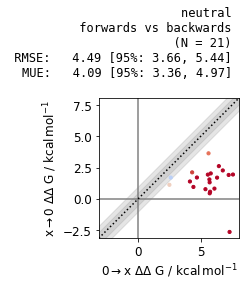

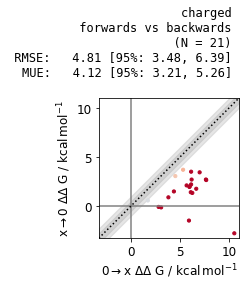

In [255]:
from beryllium import plotting, stats

graphs['neutral-comb'] = nx.DiGraph()
graphs['charged-comb'] = nx.DiGraph()

for bi in ['neutral-both','charged-both']:
    x = []
    y = []
    g = graphs[bi]
    for edge in g.edges(data=True):
        if edge[0] == 'TRY-UNI-2eddb1ff-7':
            if g.has_edge(edge[1],edge[0]):
                x.append(edge[2]['calc_DDG'])
                y.append(-g.get_edge_data(edge[1],edge[0])['calc_DDG'])
                graph = graphs[f"{bi.split('-')[0]}-comb"]
                graph.add_edge(edge[0],edge[1],
                               calc_DDG=0.5*(edge[2]['calc_DDG']-g.get_edge_data(edge[1],edge[0])['calc_DDG']), 
                               calc_dDDG=(edge[2]['calc_dDDG']**2+g.get_edge_data(edge[1],edge[0])['calc_dDDG']**2)**0.5,
                               exp_DDG=0.,exp_dDDG=0.1)
    plotting._master_plot(np.asarray(x), np.asarray(y),title=f"{bi.split('-')[0]} \n forwards vs backwards", xlabel=r'0$\rightarrow$x', ylabel=r'x$\rightarrow$0')

                               
del graphs['neutral-both']
del graphs['charged-both']

In [423]:
import csv
r_inhib_20 = {}
r_inhib_50 = {}
r_ic50 = {}
f_inhib_20 = {}
f_inhib_50 = {}
f_ic50 = {}

def _ic50_to_dG(x,s_conc=375E-9,Km=40E-6):
    Ki = x / (1 + (s_conc/Km))
    return 0.59*np.log(Ki)

def _inhibition_to_kd(percentage, concentration):
    fraction = percentage / 100.
    # using equation 7 from https://www.molbiolcell.org/doi/10.1091/mbc.e10-08-0683#F1
    kd = concentration*((1 - fraction)/fraction)
    return _ic50_to_dG(kd)

def best_guess_expt(m, threshold=10):
    # use IC50s if possible
    experimentals = [m[x] for x in m.keys() if 'IC50' in x]
    experimentals = [_ic50_to_dG(x) for x in experimentals]
    if len(experimentals) > 0:
        return (np.mean(experimentals), np.std(experimentals))  
    
    # if no IC50, try 20uM if > threshold
    experimentals = [m[x] for x in m.keys() if 'inhib20uM' in x and m[x] > threshold]
    experimentals = [_inhibition_to_kd(x,20) for x in experimentals]
    if len(experimentals) > 0:
        return (np.mean(experimentals), np.std(experimentals))   
    
    # else try 50uM
    experimentals = [m[x] for x in m.keys() if 'inhib50uM' in x if m[x] > 0]
    experimentals = [_inhibition_to_kd(x,50) for x in experimentals]
    if len(experimentals) > 0:
        return (np.mean(experimentals), np.std(experimentals))  
    else:
        return (None, None)
    


experimental = {}
with open('activity-data-2020-07-29.csv','r') as f:
    x = csv.reader(f)
    for i, row in enumerate(x):
        if i == 0:
            continue

        name = row[1]
        contents = ['r_inhib20uM','r_inhib50uM','r_IC50','f_inhib20uM','f_inhib50uM','f_IC50']
        experimental[name] = {}
        for i, c in enumerate(contents, 3):
            if row[i] != '':
                if float(row[i]) < 0.:
                    row[i] = 0.
                if float(row[i]) > 100.:
                    row[i] = 100.
                experimental[name][c] = float(row[i])
        dg , ddg = best_guess_expt(experimental[name])
        if dg is not None:
            experimental[name]['DG'] = dg
            experimental[name]['dDG'] = ddg
                
            

for g in graphs.values():
    nx.set_node_attributes(g, experimental)

/Users/brucemah/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning:

divide by zero encountered in log



/Users/brucemah/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning:

divide by zero encountered in log



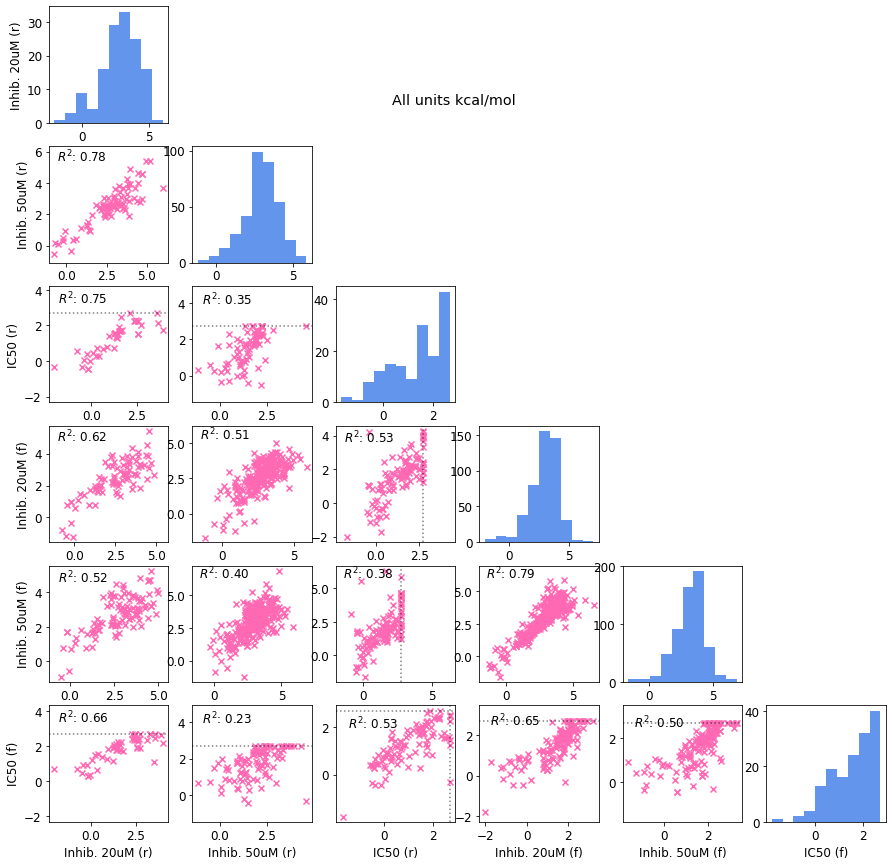

In [425]:
fig, axes = plt.subplots(ncols=6,nrows=6,figsize=(15,15))
import itertools
contents = ['r_inhib20uM','r_inhib50uM','r_IC50','f_inhib20uM','f_inhib50uM','f_IC50']
hist = {c:[] for c in contents}
scatters = {(j,i):[[],[]] for i,j in itertools.combinations(range(0,6),2)}

for exp in experimental.values():
    res = []
    for val in contents:
        if val in exp.keys():
            if 'IC50' in val:
                res.append(_ic50_to_dG(exp[val]))
            elif 'inhib20' in val and exp[val] > 0.:
                res.append(_inhibition_to_kd(exp[val],20))
            elif 'inhib50' in val and exp[val] > 0.:
                res.append(_inhibition_to_kd(exp[val],50))
            else:
                res.append(None)
        else:
            res.append(None)
            
    for i,c in enumerate(contents):
        if res[i] is not None:
            hist[c].append(res[i])

    for i,j in itertools.combinations(range(0,6),2):
        if res[i] is not None and res[j] is not None:
            scatters[(j,i)][0].append(res[i])
            scatters[(j,i)][1].append(res[j])
            
    contents_formal = ['Inhib. 20uM (r)','Inhib. 50uM (r)','IC50 (r)','Inhib. 20uM (f)','Inhib. 50uM (f)','IC50 (f)']
    for i,label in enumerate(contents_formal):
        axes[5][i].set_xlabel(f'{label}')
        axes[i][0].set_ylabel(f'{label}')
        
for i,c in enumerate(contents):
    axes[i][i].hist([x for x in hist[c] if x is not None and not np.isinf(x)],color='cornflowerblue')
    
limits = [_inhibition_to_kd(100.,20),_inhibition_to_kd(100.,50),_ic50_to_dG(99.),_inhibition_to_kd(100.,20),_inhibition_to_kd(100.,50),_ic50_to_dG(99.)]   

for i,j in itertools.combinations(range(0,6),2):
    xs = []
    ys = []
    for x,y in zip(scatters[(j,i)][0], scatters[(j,i)][1]):
        if x is not None and y is not None and not np.isinf(x) and not np.isinf(y):
            xs.append(x)
            ys.append(y)

    axes[j][i].scatter(xs,ys,color='hotpink',marker='x')
    s = stats.bootstrap_statistic(np.asarray(xs),np.asarray(ys), statistic='R2')
    string = f"$R^2$: {s['mle']:.2f}"  
    
    
    y_low, y_high = axes[j][i].get_ylim()
    x_low, x_high = axes[j][i].get_xlim()
    low = min(x_low,y_low)
    high = max(x_high,y_high)
    axes[j][i].text(low+0.5, high-1.,string)    

    axes[j][i].set_xlim(low,high)
    axes[j][i].set_ylim(low,high)
    axes[i][j].axis('off')
    
    # now plot the limits
    axes[j][i].hlines(limits[j],low,high,'k',linestyle=':',alpha=0.5)
    axes[j][i].vlines(limits[i],low,high,'k',linestyle=':',alpha=0.5)
plt.suptitle('All units kcal/mol',y=0.8)

plt.show()

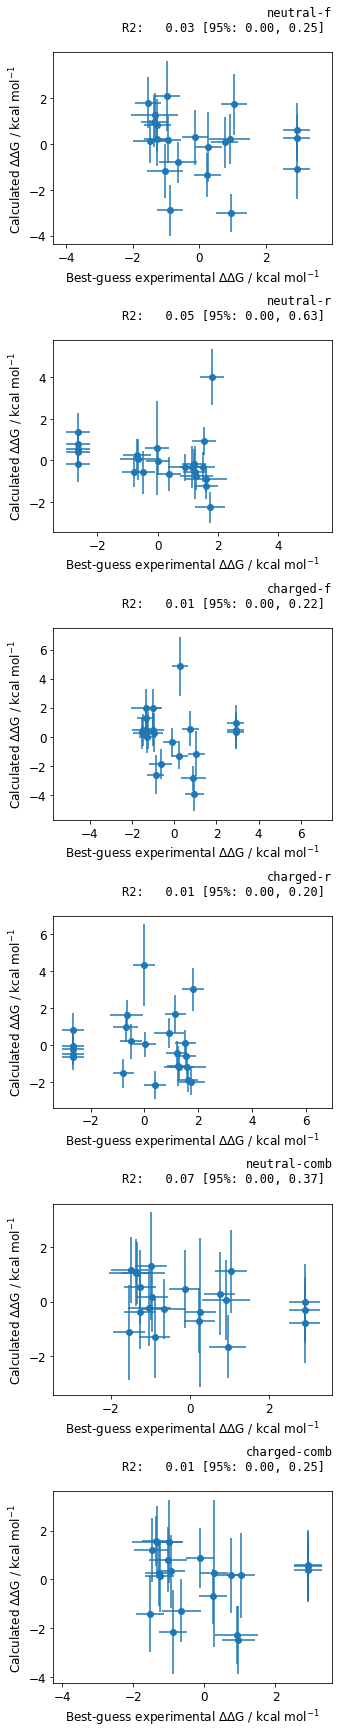

In [428]:
fig, axes = plt.subplots(ncols=1,nrows=len(graphs),figsize=(5, 5*len(graphs)))


for i, protein in enumerate(graphs.keys()):
    g = graphs[protein]
    xs = []
    x_err = []
    y_err = []
    ys = []
    for edge in g.edges(data=True):
        try:
            expt = nx.get_node_attributes(g,'DG')[edge[0]] - nx.get_node_attributes(g,'DG')[edge[1]]
            dexpt = (nx.get_node_attributes(g,'dDG')[edge[0]]**2 + nx.get_node_attributes(g,'dDG')[edge[1]]**2)**0.5
            ys.append(edge[2]['calc_DDG'])
            y_err.append(edge[2]['calc_dDDG'])
            xs.append(expt)
            x_err.append(dexpt)
        except:
            continue
    xs = xs - np.mean(xs)
    ys = ys - np.mean(ys)
    axes[i].scatter(xs,ys)
    axes[i].errorbar(xs,ys,xerr=x_err,yerr=y_err,ls='none')
    y_low, y_high = axes[i].get_ylim()
    x_low, x_high = axes[i].get_xlim()
    low = min(x_low,y_low)
    high = max(x_high,y_high)
    axes[i].set_xlim(low,high)
    axes[i].set_ylim(low,high)

    statistics_string = f'{protein}\n'
    for statistic in ['R2']:
        s = stats.bootstrap_statistic(np.asarray(xs),np.asarray(ys), statistic=statistic)
        string = f"{statistic}:   {s['mle']:.2f} [95%: {s['low']:.2f}, {s['high']:.2f}] " + "\n"
        statistics_string += string
    axes[i].set_title(statistics_string, fontsize=12, loc='right', horizontalalignment='right', family='monospace')

    axes[i].set_ylabel(f'Calculated ΔΔG '+r'/ kcal mol$^{-1}$')
    axes[i].set_xlabel(f'Best-guess experimental ΔΔG '+r'/ kcal mol$^{-1}$')

plt.subplots_adjust(hspace = 0.5,wspace = 0.5) 
plt.show()


/Users/brucemah/miniconda3/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:116: RuntimeWarning:

invalid value encountered in double_scalars

/Users/brucemah/miniconda3/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:128: RuntimeWarning:

invalid value encountered in double_scalars



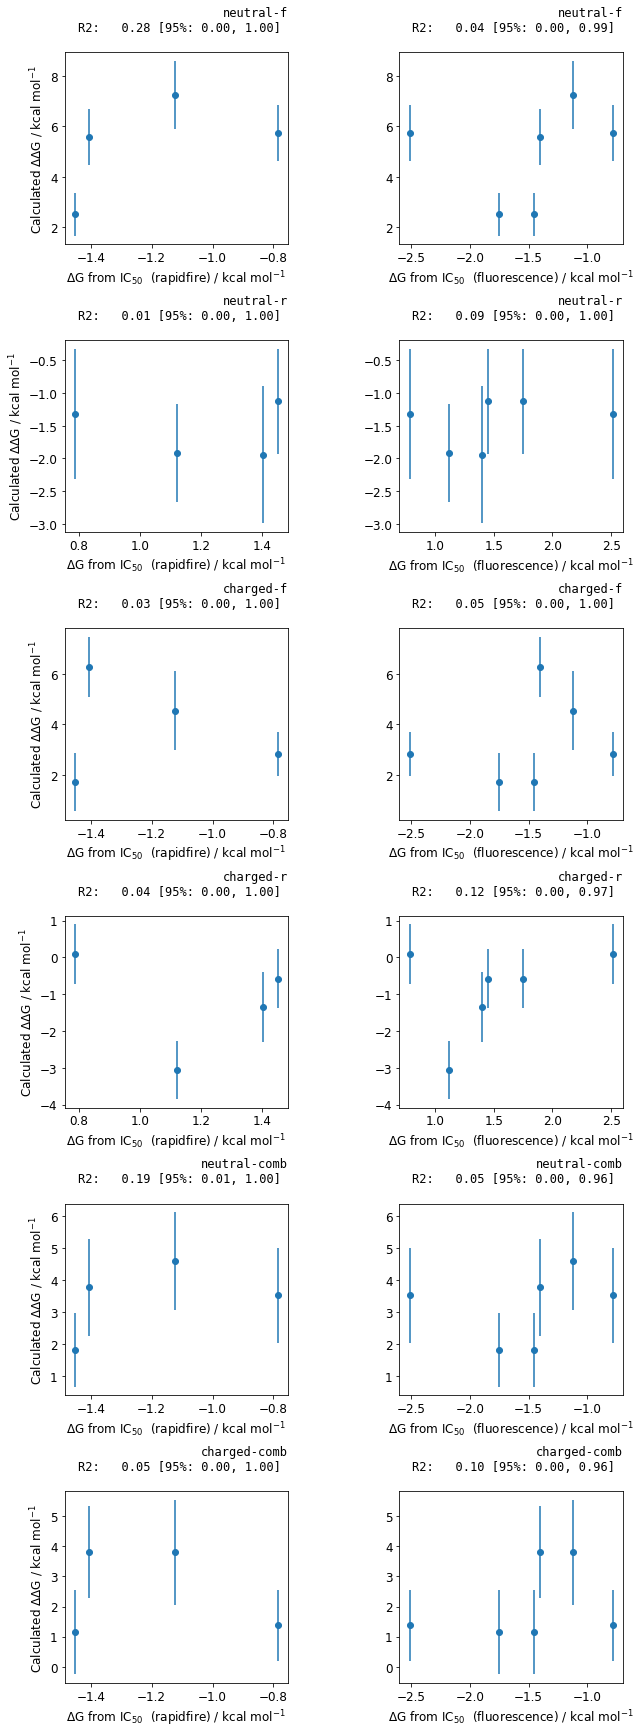

In [350]:
fig, axes = plt.subplots(ncols=2,nrows=len(graphs),figsize=(10, 5*len(graphs)))


for i, protein in enumerate(graphs.keys()):
    g = graphs[protein]
    xs = []
    y_err = []
    ys = []
    for j, assay in enumerate(['f','r']):
        for edge in g.edges(data=True):
            try:
                # TODO if either of these are 99, we want to color the associated datapoint different
                expt = nx.get_node_attributes(g,f'{assay}_IC50')[edge[0]] / nx.get_node_attributes(g,f'{assay}_IC50')[edge[1]]
                ys.append(edge[2]['calc_DDG'])
                y_err.append(edge[2]['calc_dDDG'])
                xs.append(0.59*np.log(expt))
            except:
                continue
        
        axes[i][j].scatter(xs,ys)
        axes[i][j].errorbar(xs,ys,yerr=y_err,ls='none')
#         low_lim, high_lim = axes[i][j].get_ylim()[0],axes[i][j].get_ylim()[1]
#         axes[i][j].vlines(0.59*np.log(99),low_lim, high_lim)
#         axes[i][j].set_ylim(low_lim, high_lim)
        
        statistics_string = f'{protein}\n'
        for statistic in ['R2']:
            s = stats.bootstrap_statistic(np.asarray(xs),np.asarray(ys), statistic=statistic)
            string = f"{statistic}:   {s['mle']:.2f} [95%: {s['low']:.2f}, {s['high']:.2f}] " + "\n"
            statistics_string += string
        axes[i][j].set_title(statistics_string, fontsize=12, loc='right', horizontalalignment='right', family='monospace')

    axes[i][0].set_ylabel(f'Calculated ΔΔG '+r'/ kcal mol$^{-1}$')
    axes[i][0].set_xlabel(r'ΔG from IC$_{50}$  (rapidfire) '+r'/ kcal mol$^{-1}$')
    axes[i][1].set_xlabel(r'ΔG from IC$_{50}$  (fluorescence) '+r'/ kcal mol$^{-1}$')
plt.subplots_adjust(hspace = 0.5,wspace = 0.5) 
plt.show()


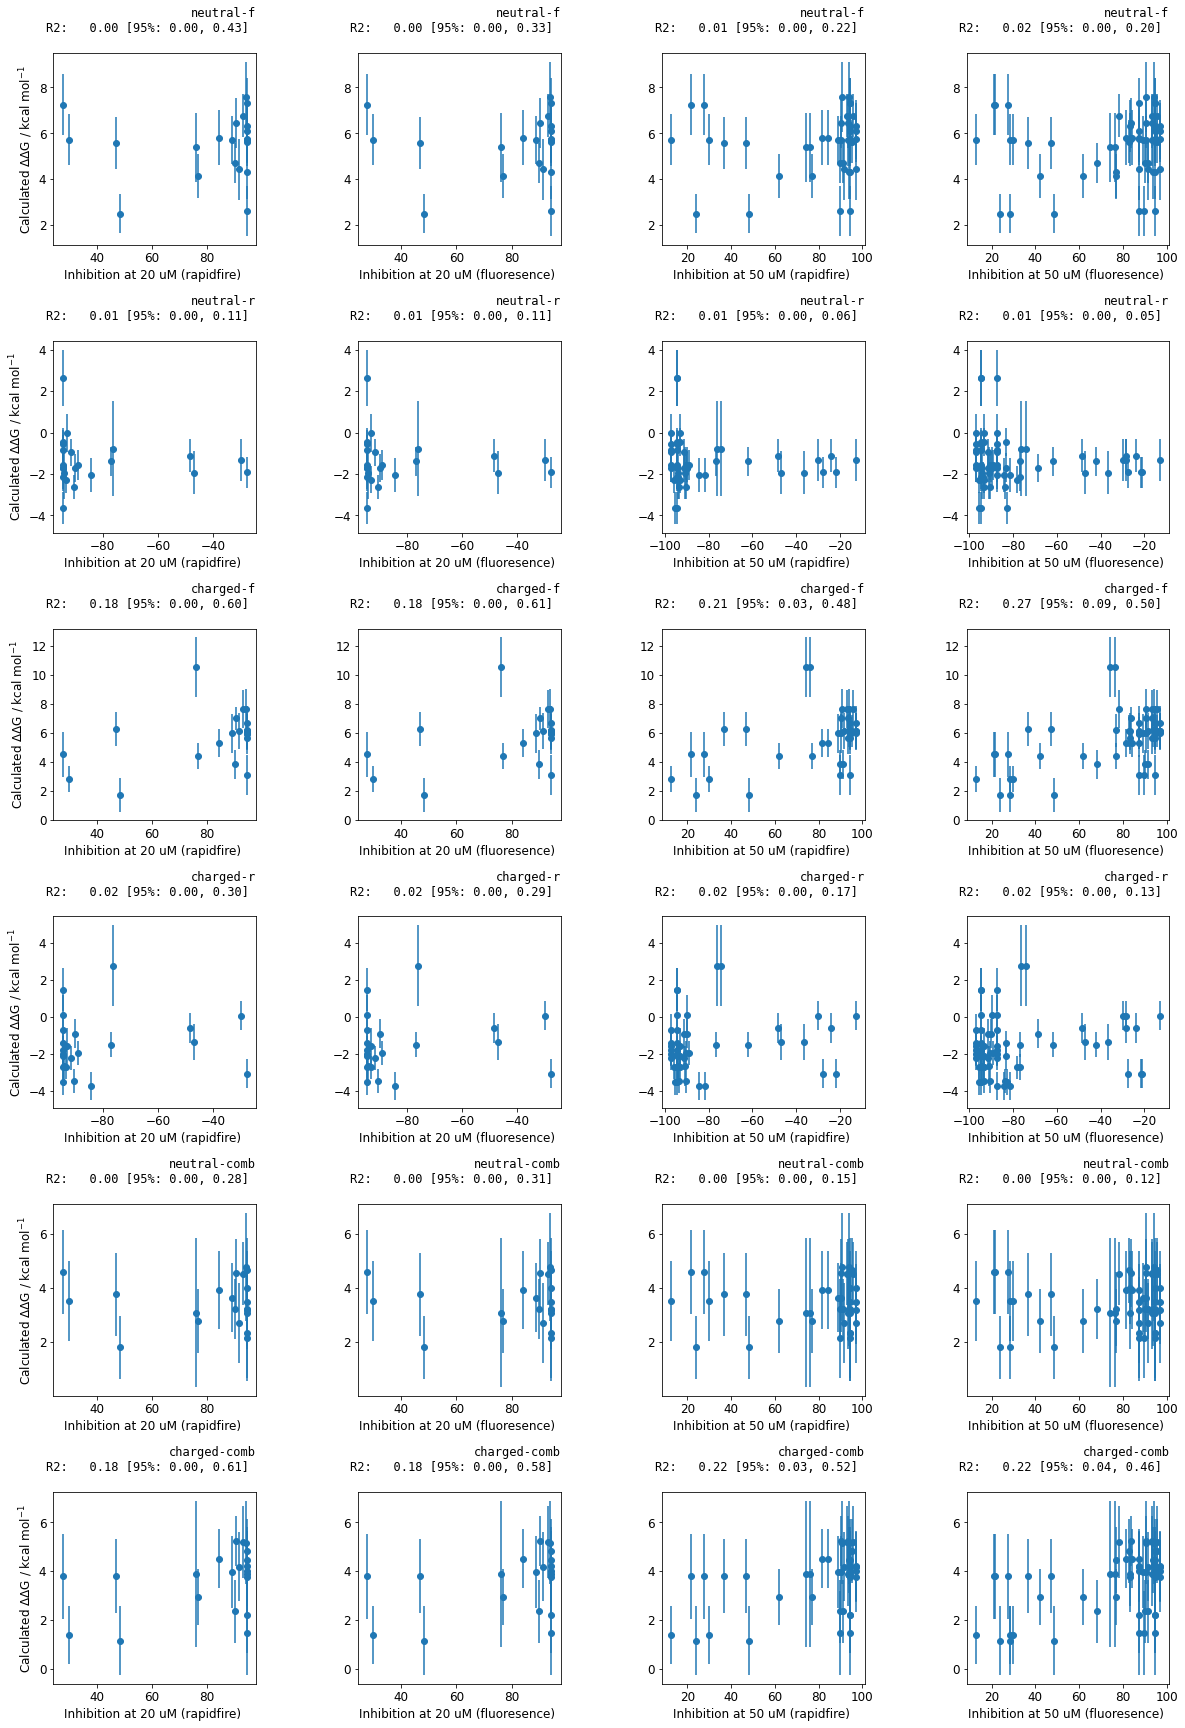

In [351]:
fig, axes = plt.subplots(ncols=4,nrows=len(graphs),figsize=(20, 5*len(graphs)))


for i, protein in enumerate(graphs.keys()):
    g = graphs[protein]
    xs = []
    y_err = []
    ys = []
    for j, assay in enumerate(['f_inhib20uM','r_inhib20uM','f_inhib50uM','r_inhib50uM']):
        for edge in g.edges(data=True):
            try:
                expt = nx.get_node_attributes(g,assay)[edge[0]] - nx.get_node_attributes(g,assay)[edge[1]]
                ys.append(edge[2]['calc_DDG'])
                y_err.append(edge[2]['calc_dDDG'])
                xs.append(expt)
            except:
                continue
        axes[i][j].scatter(xs,ys)
        axes[i][j].errorbar(xs,ys,yerr=y_err,ls='none')
#         axes[i][j].set_xlim(0.,100.)

        
        statistics_string = f'{protein}\n'
        for statistic in ['R2']:
            s = stats.bootstrap_statistic(np.asarray(xs),np.asarray(ys), statistic=statistic)
            string = f"{statistic}:   {s['mle']:.2f} [95%: {s['low']:.2f}, {s['high']:.2f}] " + "\n"
            statistics_string += string
        axes[i][j].set_title(statistics_string, fontsize=12, loc='right', horizontalalignment='right', family='monospace')

    axes[i][0].set_ylabel(f'Calculated ΔΔG '+r'/ kcal mol$^{-1}$')
    axes[i][0].set_xlabel(r'Inhibition at 20 uM (rapidfire) ')
    axes[i][1].set_xlabel(r'Inhibition at 20 uM (fluoresence) ')
    axes[i][2].set_xlabel(r'Inhibition at 50 uM (rapidfire) ')
    axes[i][3].set_xlabel(r'Inhibition at 50 uM (fluoresence) ')
plt.subplots_adjust(hspace = 0.5,wspace = 0.5) 
plt.show()


In [295]:
# # enumerated stereochemistry NEED TO COMBINE ESTIMATE FROM DIFFERENT STEREOCHEMISTRIES
# for title in title_to_index.keys():
#     print(title)

JAN-GHE-83b26c96-9
JAN-GHE-83b26c96-16
BEN-DND-93268d01-15
ANN-UNI-98d2bf15-2
LON-WEI-0a73fcb8-2
ADA-UNI-f8e79267-2
GAB-REV-70cc3ca5-20
BAR-COM-0f94fc3d-59
MAT-POS-590ac91e-19
MAT-POS-590ac91e-21
EDJ-MED-e58735b6-3
ALP-POS-95b75b4d-2
CHR-SOS-7098f804-11
CHR-SOS-7098f804-21
MAT-POS-590ac91e-27
JAN-GHE-83b26c96-14
ANT-DIA-3c79be55-4
TRY-UNI-714a760b-5
TRY-UNI-714a760b-20
JAN-GHE-83b26c96-13
EDG-MED-0da5ad92-13
JAN-GHE-83b26c96-2
TRY-UNI-714a760b-18
AGN-NEW-c7b24fe3-5
EDG-MED-0da5ad92-2
ERI-UCB-5b47150d-6
JAN-GHE-83b26c96-12
TRY-UNI-714a760b-22
JAG-UCB-a3ef7265-3
EDJ-MED-49816e9b-2
TRY-UNI-2eddb1ff-7
JAN-GHE-83b26c96-23
MAT-POS-590ac91e-8
BAR-COM-0f94fc3d-45
EDG-MED-0da5ad92-18
BAR-COM-0f94fc3d-23
ALP-POS-95b75b4d-1
TRY-UNI-714a760b-6
AGN-NEW-c7b24fe3-3
ADA-UNI-f8e79267-5
MAT-POS-590ac91e-18
CHR-SOS-7098f804-14
JAN-GHE-83b26c96-3
MAT-POS-590ac91e-22
AGN-NEW-c7b24fe3-4
JAN-GHE-83b26c96-11
MAT-POS-590ac91e-12
ALP-POS-95b75b4d-6
BAR-COM-0f94fc3d-58
BAR-COM-0f94fc3d-46
JAN-GHE-83b26c96-15
MAT

In [296]:
# def _inhibition_to_kd(percentage, concentration):
#     fraction = percentage / 100.
#     # using equation 7 from https://www.molbiolcell.org/doi/10.1091/mbc.e10-08-0683#F1
#     kd = concentration*((1 - fraction)/fraction)
#     return kd

# ### combining all
# for ligand in index_to_title.keys():
#     inhib = r_inhib_20[index_to_title[ligand]]
#     if inhib is not None and inhib > 0.:
#         kd_a = _inhibition_to_kd(inhib,20.)
#     else:
#         kd_a = None
#     inhib = r_inhib_50[index_to_title[ligand]]
#     if inhib is not None and inhib > 0.:
#         kd_b = _inhibition_to_kd(inhib,50.)
#     else:
#         kd_b = None
#     print(kd_a, kd_b, r_ic50[index_to_title[ligand]])

KeyError: 'JAN-GHE-83b26c96-9'

In [ ]:
fig, axes = plt.subplots(ncols=2,nrows=len(graphs),figsize=(10, 5*len(graphs)),sharey=True)

for i, protein in enumerate(graphs.keys()):
    g = graphs[protein]
    for j, item in enumerate([r_ic50,f_ic50]):
        xs = []
        y_err = []
        ys = []
        for edge in g.edges(data=True):
            if edge[0] == 0:
                index = edge[1]
            else:
                index = edge[0]
            ic = item[index_to_title[index]]
            if ic is not None:
                ys.append(edge[2]['calc_DDG'])
                y_err.append(edge[2]['calc_dDDG'])
                xs.append(0.59*np.log(ic))
            elif 
        axes[i][j].scatter(xs,ys)
        axes[i][j].errorbar(xs,ys,yerr=y_err,ls='none')

        
        statistics_string = f'{protein}\n'
        for statistic in ['R2']:
            s = stats.bootstrap_statistic(np.asarray(xs),np.asarray(ys), statistic=statistic)
            string = f"{statistic}:   {s['mle']:.2f} [95%: {s['low']:.2f}, {s['high']:.2f}] " + "\n"
            statistics_string += string
        axes[i][j].set_title(statistics_string, fontsize=12, loc='right', horizontalalignment='right', family='monospace')

    axes[i][0].set_ylabel(f'Calculated ΔΔG '+r'/ kcal mol$^{-1}$')
    axes[i][0].set_xlabel(r'ΔG from IC$_{50}$  (rapidfire) '+r'/ kcal mol$^{-1}$')
    axes[i][1].set_xlabel(r'ΔG from IC$_{50}$  (fluorescence)'+r'/ kcal mol$^{-1}$')
plt.subplots_adjust(hspace = 0.5,wspace = 0.5) 
plt.show()

In [ ]:
# enumerated stereochemistry

# for title in title_to_index.keys():
#     print(title)

In [189]:
fig1_left = {1:'ADA-UCB-6c2cb422-1',
2:'TRY-UNI-714a760b-6',
3:'EDG-MED-0da5ad92-2',
4:'JAN-GHE-5a013bed-2',
5:'JAN-GHE-5a013bed-3',
6:'JAN-GHE-5a013bed-1'}


# fig1_r = {
# 1'TRY-UNI-714a760b-6'
# 2'JAN-GHE-83b26c96-12'
# 3'TRY-UNI-714a760b-20'
# 4
# 5


In [437]:
g = graphs['neutral-f']
for title in fig1_left.values():
    try:
        print(g.nodes.data()[title])

In [439]:
experimental[title]

{'r_inhib50uM': 28.6594331524507,
 'r_IC50': 73.3563140602343,
 'f_inhib20uM': 39.57277,
 'f_inhib50uM': 70.405075,
 'f_IC50': 14.1625652028387,
 'DG': 2.043544106472776,
 'dDG': 0.48519427380776525}

In [440]:
experimental['TRY-UNI-2eddb1ff-7']

{'r_inhib50uM': 87.191315835,
 'r_IC50': 0.940748777754165,
 'f_inhib20uM': 94.4703,
 'f_inhib50uM': 97.00562,
 'f_IC50': 3.6098563119233,
 'DG': 0.3551582187249122,
 'dDG': 0.3967003996612177}

In [445]:
for edge in g.edges(data=True):
    print(experimental[edge[1]])

{'r_inhib50uM': 0.0, 'f_inhib20uM': 0.0, 'f_inhib50uM': 2.540904, 'DG': 4.454266664763582, 'dDG': 0.0}
{'r_inhib50uM': 58.930355553955, 'r_IC50': 66.3508066283698, 'f_inhib20uM': 64.546535, 'f_inhib50uM': 84.22906, 'f_IC50': 13.6719871340003, 'DG': 2.0035344689963206, 'dDG': 0.46598403936773336}
{'r_inhib50uM': 0.0, 'f_inhib20uM': 0.0, 'f_inhib50uM': 7.303486, 'DG': 3.8017657579982713, 'dDG': 0.0}
{'r_inhib50uM': 4.57, 'f_inhib20uM': 0.0, 'f_inhib50uM': 1.67086995, 'DG': 4.401175519186263, 'dDG': 0.3056483533480998}
{'r_inhib50uM': 3.35419548562795, 'f_inhib20uM': 4.102835, 'f_inhib50uM': 3.5664645, 'DG': 4.2667335196450695, 'dDG': 0.018750671652795425}
{'r_inhib50uM': 0.0, 'f_inhib20uM': 0.0, 'f_inhib50uM': 0.0}
{'r_inhib50uM': 8.855, 'f_inhib20uM': 1.3484824, 'f_inhib50uM': 1.3631175, 'DG': 4.253464470078363, 'dDG': 0.575309449546247}
{'r_inhib50uM': 45.2875347336265, 'f_inhib20uM': 17.61691, 'f_inhib50uM': 35.208985, 'DG': 2.672063925309131, 'dDG': 0.0}
{'r_inhib50uM': 0.0, 'f_inhib